In [1]:
%load_ext autoreload
%autoreload 2
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

import tensorflow as tf
tf.enable_eager_execution();

import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Layer, multiply, Concatenate,Flatten
MISSING_INPUT_CONSTANT = -10
IGNORE_OUTPUT_CONSTANT = -5
from tensorflow.keras import backend as K

from DataGenerator import UniformDataGenerator
from SubNet import SubjectNetwork
from ObjNet import ObjectNetwork
from MaskOptimizer import MaskOptimizer
from FeatureSelector import FeatureSelector
import os,datetime
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%load_ext tensorboard
%tensorboard --logdir {logs_base_dir}
!nvidia-smi

/home/mbcxwmw3/miniconda2/envs/ml/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mbcxwmw3/miniconda2/envs/ml/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mbcxwmw3/miniconda2/envs/ml/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mbcxwmw3/miniconda2/envs/ml/lib/python3.7/s

Reusing TensorBoard on port 6006 (pid 9150), started 6 days, 6:15:15 ago. (Use '!kill 9150' to kill it.)

Mon Jun  8 19:22:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.26                 Driver Version: 396.26                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  Off  | 00000000:01:00.0  On |                  N/A |
| 41%   83C    P2   171W / 250W |  11882MiB / 12212MiB |     53%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX TIT...  Off  | 00000000:02:00.0 Off |                  N/A |
| 22%   40C    P8    16W / 250W |    120MiB / 12212MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [2]:
import CCM_master.examples.make_synthetic_data as dg
import CCM_master.core.ccm as ccm 
import numpy as np

In [3]:
import sys
def squared_error(y_true,y_pred):
    return (y_true-y_pred)*(y_true-y_pred)
def keras_mean(losses):
    return K.mean(losses)
def numpy_mean(losses):
    return np.mean(losses)
def progressbar(it, prefix="", size=60, file=sys.stdout):
    count = len(it)
    def show(j):
        x = int(size*j/count)
        file.write("%s[%s%s] %i/%i\r" % (prefix, "#"*x, "."*(size-x), j, count))
        file.flush()        
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    file.write("\n")
    file.flush()

In [4]:
K.clear_session()

In [5]:
import math,random

def get_gen_synth_100(w,noise_sigma):
    #correlations = (-1)*np.ones(shape=(len(w)),2)
    correlations_mat = np.eye(len(w))
    r = np.random.randint(3,size=len(w))
    i=0
    while i<len(w)-2:
        if(r[i]==1):
            frac = random.random()
            #n1 = random.gauss(0,noise_sigma)
            #n2 = random.gauss(0,noise_sigma)
            correlations_mat[i+1,i] = (1-frac)*correlations_mat[i,i]#+n1
            correlations_mat[i,i] =frac*correlations_mat[i,i]#+n2
            i+=2
        elif(r[i]==2):
            frac = random.random()
            frac2= frac*random.random()
            #n1 = random.gauss(0,noise_sigma)
            #n2 = random.gauss(0,noise_sigma)
            #n3 = random.gauss(0,noise_sigma)
            correlations_mat[i+1,i] = frac*frac2*correlations_mat[i,i]#+n1
            correlations_mat[i+2,i] = frac*(1-frac2)*correlations_mat[i,i]#+n2
            correlations_mat[i,i] = (1-frac)*correlations_mat[i,i]#+n3
            i+=3
        else:
            i+=1
        def gen(x):
            return np.sum(x*w)   
        def get_X(x):
            #return x@correlations_mat 
            x_new = x @ correlations_mat
            where_correlated = np.argwhere(correlations_mat%1!=0 )
            where_correlated = np.unique(where_correlated[:,1])
            noise_shape = (len(x_new),len(where_correlated))
            #print(noise_shape)
            x_new[:,where_correlated] += np.random.normal(0,0.1,noise_shape) 
            #print(where_correlated)
            return x_new
    return gen,get_X,correlations_mat
import ast

def get_X_from_cors_mat(x,c_m):
            #return x@correlations_mat 
            x_new = x @ c_m
            where_correlated = np.argwhere(c_m%1!=0 )
            where_correlated = np.unique(where_correlated[:,1])
            noise_shape = (len(x_new),len(where_correlated))
            x_new[:,where_correlated] += np.random.normal(0,0.1,noise_shape)             
            return x_new
def get_y_from_x(x,w):
            return np.sum(x*w)
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])


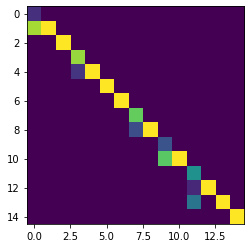

(1024, 10)
(1024,)
(512, 10)
(512,)


In [48]:
import CCM_master.examples.make_synthetic_data as md
from sklearn.model_selection import KFold,StratifiedKFold
n_samples = 512
n_test_samples = 1024
dataset_type = 'orange_skin'
label= "synth_test_"+dataset_type+"_"
data_batch_size = 32
mask_batch_size = 32
data_size = 15
data_shape = (data_size,)
unmasked_data_size = 5

pert_size = 2

np.random.seed(1)
random.seed(1)

#cors_mat =np.array(ast.literal_eval('[[0.9024405598933164, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0975594401066836, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.3817343695941917, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.2803135379044076, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.3379520925014007, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.7425544345869612, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.25744556541303876, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.28191380676486477, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7180861932351352, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9237352224091069, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0022325495748119328, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07403222801608118, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15433703529639575, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5601808229265703, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2854821417770339, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3197752845228702, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6802247154771298, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8555848395400195, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00010202527355770192, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1443131351864228, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.061694404559726745, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9383055954402733, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8459646660767514, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15403533392324864, 1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]]'))
#w = np.arange(0,1,1.0/25.0)
w = np.arange(data_size+1,1,-1)
_,_,cors_mat = get_gen_synth_100(w,0.01)
plt.imshow(cors_mat)
plt.show()


if(dataset_type=='linear'):
    X = np.random.normal(0,1,size =(n_test_samples+n_samples)*data_size )
    X = np.reshape(X,newshape=((n_test_samples+n_samples),)+data_shape)
    X = get_X_from_cors_mat(X,cors_mat)
    y = X@w
    y = (y - np.mean(y))/np.std(y)
    y += np.random.normal(0,0.1,len(y))
    y = (y - np.mean(y))/np.std(y)
    X_ = X[:n_samples]
    X_te = X[n_samples:]
    y_ = y[:n_samples]
    y_te = y[n_samples:]
    X=X_
    y=y_

    
else:
    X,y = md.generate_data(n=n_samples, datatype=dataset_type, seed = 0)
    X_te,y_te = md.generate_data(n=n_test_samples, datatype=dataset_type, seed = 0)
    data_size = X.shape[1]
    data_shape = (data_size,)

if(dataset_type=='XOR'or dataset_type=='orange_skin'):
    KF = StratifiedKFold(5, shuffle=True,random_state=0)
else:
    KF = KFold(5, shuffle=True,random_state=0)
folds =  KF.split(X,y)
indices = [i for i in folds] 
x_range = np.arange(data_size)

print(X_te.shape)
print(y_te.shape)
print(X.shape)
print(y.shape)

In [8]:
from os import path

class ResultSaver:
    def __init__(self):
        self.methods ={"Ours_(s=5)": 0,"CCM": 1,"BAHSIC": 2,"RFE": 3,"AvGrad": 4,"DFS": 5,"RF": 6,"LASSO": 7,"FS": 8,"MRMR": 9,"Ours_(s=7)": 10,"Ours_(s=9)": 11,"Ours_(s=8)": 12,"Ours_(s=4)": 13,"Ours_(s=6)": 14}
        self.datasets = {"linear":0,"regression":1,"XOR":2,"orange_skin":3}
        self.importances = [[np.empty(0) for i in range(len(self.methods))] for j in range(len(self.datasets))]
        self.masks = [[np.empty(0) for i in range(len(self.methods))] for j in range(len(self.datasets))]
        self.performances = [[np.empty(0) for i in range(len(self.methods))] for j in range(len(self.datasets))]
        self.method_names = list(self.methods.keys())
        self.dataset_names = list(self.datasets.keys())
        self.if_filter_method=[0,1,1,1,0,0,0,1,0,1,0,0,0,0,0]
        self.load()
    def reset(self):
        self.importances = [[np.empty(0) for i in range(len(self.methods))] for j in range(len(self.datasets))]
        self.masks = [[np.empty(0) for i in range(len(self.methods))] for j in range(len(self.datasets))]
        self.performances = [[np.empty(0) for i in range(len(self.methods))] for j in range(len(self.datasets))]
        self.save()
    def save(self):
        for i in range(len(self.datasets)):        
            for j in range(len(self.methods)):
                np.save("data/"+self.dataset_names[i]+"_"+self.method_names[j]+"_imp", self.importances[i][j])
                np.save("data/"+self.dataset_names[i]+"_"+self.method_names[j]+"_mask", self.masks[i][j])
                np.save("data/"+self.dataset_names[i]+"_"+self.method_names[j]+"_perf", self.performances[i][j])
    def load(self):
        for i in range(len(self.datasets)):        
            for j in range(len(self.methods)):
                if(path.exists("data/"+self.dataset_names[i]+"_"+self.method_names[j]+"_imp.npy")):
                    self.importances[i][j]=  np.load("data/"+self.dataset_names[i]+"_"+self.method_names[j]+"_imp.npy",allow_pickle=True)
                    self.masks[i][j]=np.load("data/"+self.dataset_names[i]+"_"+self.method_names[j]+"_mask.npy",allow_pickle=True)
                    self.performances[i][j]=np.load("data/"+self.dataset_names[i]+"_"+self.method_names[j]+"_perf.npy",allow_pickle=True)
                else:
                    print("Cannot load data for: "+str(self.dataset_names[i])+" "+str(self.method_names[j]))
    def update(self,method,dataset,imp=None,perf=None,mask=None,features=None):
        if (mask is None) and (features is None):
            mask = ResultSaver.get_boolean_mask(ResultSaver.get_feature_set_from_importances(imp,unmasked_data_size))
        if (imp is None) and (features is None):
            imp = ResultSaver.get_importances_from_feature_set(np.nonzero(mask)[1])
            print(imp)
        if (mask is None) and (imp is None):            
            imp = ResultSaver.get_importances_from_feature_set(features)
            mask = ResultSaver.get_boolean_mask(features)
        if not (perf is None):
            self.performances[self.datasets[dataset]][self.methods[method]] = perf
        else:
            self.performances[self.datasets[dataset]][self.methods[method]] = np.empty(shape=0)
        self.masks[self.datasets[dataset]][self.methods[method]] = mask
        self.importances[self.datasets[dataset]][self.methods[method]] = imp
        print("Updated importances: "+str(imp))
        print("Updated masks: "+str(mask))
        self.save()
        self.save_graphic_importances(method,dataset)
 
    def get_importances_from_feature_set(features):
        print("Getting importances from: "+str(features))
        importances = np.zeros((len(features),data_size))
        for i in range(len(features)):
            for j in range(len(features[i])):
                importances[i,features[i][j]] = 1.0
        return importances
    def get_feature_set_from_importances(importances,n_top):
        return (np.argsort(importances,axis=1)[:,-n_top:])
    def get_boolean_mask(features):
        m = np.zeros((len(features),data_size))
        for i in range(len(features)):
            m[i,features[i]] = 1.0
        return m
    def save_graphic_importances(self,method_name,dataset_name):
        if not os.path.exists("graphics/"+method_name):
            os.makedirs("graphics/"+method_name)
        plot_label="ACC"
        if(dataset_name=="regression" or dataset_name=="linear"):
            plot_label = "MSE"
        imp = self.importances[self.datasets[dataset_name]][self.methods[method_name]]
        mask = self.masks[self.datasets[dataset_name]][self.methods[method_name]]
        metric = self.performances[self.datasets[dataset_name]][self.methods[method_name]]
        print("MEtric: "+str(metric))
        if(metric.size==0):metric=None
        number_of_k_folds =len(imp)
        count_nonzero = np.squeeze(np.sum(mask,axis=0))
        used_features = np.squeeze(np.argwhere(count_nonzero>0))
        common_features = np.squeeze(np.argwhere(count_nonzero==number_of_k_folds))
        imp *= np.squeeze(np.array(mask))
        imp = np.squeeze(np.sum(imp,axis=0))
        imp[used_features] = imp[used_features]/count_nonzero[used_features]
        print(imp)
        colours = ["red"]*len(imp)
        if not(metric is None):
            metric_mean = np.squeeze(np.mean(metric))
            metric_err = np.squeeze(np.std(metric))/np.sqrt(metric.size)
        if common_features.size!=0:
            print("Detecting common features: "+str(common_features))
            if(common_features.size==1):
                colours[common_features]="blue"
            else:
                for f in common_features:
                    print("Common feature: "+str(f) )
                    colours[f]="blue"
        f =plt.figure(figsize=(5,2.5))
        plt.bar(np.arange(len(imp)),imp,color=colours)
        ax = f.axes[0]
        #if np.max(imp[used_features])==np.min(imp[used_features]):
        #    print("Setting maximum of y axis to twice the size.")
        ax.set_ylim([plt.ylim()[0],plt.ylim()[1]*1.33])
        if not(metric is None):
            plt.text(3,plt.ylim()[1]-((plt.ylim()[1]-plt.ylim()[0])/10), plot_label+r': $'+str(round(metric_mean, 3))+'\pm '+str(round(metric_err, 3))+'$', fontsize=16)
        if("Ours" in method_name):
            plt_title=method_name[:4]
        elif("MRMR" == method_name):
            plt_title="mRMR"
        else:
            plt_title=method_name
            
        if(self.if_filter_method[self.methods[method_name]]==1):
            plt_title += "*"
        plt.title(plt_title, fontsize=20)
        plt.ylabel("Importance")
        ax.set_xticks(np.arange(len(x_range)))
        plt.axhline(y=0,color='black',linestyle="--",linewidth=1)
        ax.set_yticklabels([])
        plt.xticks(fontsize=14)
        plt.savefig("graphics/"+method_name+"/"+dataset_name+".png")
        plt.show()
    def validate_perf_SVM(self,method,dataset,n_features,X,y,X_te,y_te):
        from sklearn import svm
        print(method+" / "+dataset)
        #print(X[0])
        #print(y[0])
        #print(X_te[0])
        #print(y_te[0])
        #print(X.shape)
        #print(X_te.shape)
        imp=self.importances[self.datasets[dataset]][self.methods[method]]
        #print("Importances:")
        #print(imp)
        features = ResultSaver.get_feature_set_from_importances(imp,n_features)
        perfs = []
        if(len(y.shape)>1): # change forom one hot to labels
            if(y.shape[1]>1):
                y = np.nonzero(y)[1]
                y_te = np.nonzero(y_te)[1]
        feature_subset_index =0
        for i in indices:
            X_tr = X[i[0],:]
            X_tr = X_tr[:,features[feature_subset_index]]
            y_tr = y[i[0]]
            if(dataset=="XOR" or dataset=="orange_skin"):
                mod_svm = svm.SVC(decision_function_shape='ovo',kernel='rbf')
                mod_svm.fit(X_tr,y_tr)
                perfs.append(mod_svm.score(X_te[:,features[feature_subset_index]],y_te))
            else:    
                print("Regression")
                mod_svm = svm.SVR(kernel='rbf',gamma="scale",C=1)
                mod_svm.fit(X_tr,y_tr)
                y_pred = mod_svm.predict(X_te[:,features[feature_subset_index]])
                print(y_pred[:5])
                print(y_te[:5])
                print(X_tr.shape)
                perfs.append(np.mean((y_pred-y_te)*(y_pred-y_te)))
            print("Using features: "+str(features[feature_subset_index]),end='\t')
            print("Perf: "+str(perfs[-1]))
            feature_subset_index+=1

        perfs = np.array(perfs)
        print("MEAN: "+str(np.mean(perfs))+" +- "+str(np.std(perfs)))
        self.performances[self.datasets[dataset]][self.methods[method]] = np.copy(perfs)
    def redraw_all(self):
        for dataset in self.dataset_names:
            for method in self.method_names:
                print(dataset)
                print(method)
                if(self.importances[self.datasets[dataset]][self.methods[method]].size>0):
                    self.save_graphic_importances(method,dataset)
    def validate_perf_DNN(self,method,dataset,n_features,X,y,X_te,y_te):
        from sklearn import svm
        print(method+" / "+dataset)

        imp=self.importances[self.datasets[dataset]][self.methods[method]]
        features = ResultSaver.get_feature_set_from_importances(imp,n_features)
        perfs = []
        feature_subset_index =0
        for i in indices:
            X_tr = X[i[0],:]
            X_tr = X_tr[:,features[feature_subset_index]]
            X_val = X[i[1],:]
            X_val = X_val[:,features[feature_subset_index]]
            y_tr = y[i[0]]
            y_val = y[i[1]]
            inp = Input((n_features))
            x = Dense(50,activation='tanh')(inp)
            x = Dense(25,activation='tanh')(x)
            x = Dense(10,activation='tanh')(x)
            if(dataset_type=="linear" or dataset_type=="regression"):x = Dense(1,activation='linear')(x)
            elif (dataset_type=="orange_skin"):x = Dense(1,activation='sigmoid')(x)
            elif (dataset_type=="XOR"):x = Dense(4,activation='softmax')(x)
            mod_new = Model(inputs=inp,outputs=x)
            if(dataset_type=="linear" or dataset_type=="regression"):
                mod_new.compile(optimizer='adam',loss='mse')
            elif (dataset_type=="orange_skin"):
                mod_new.compile(optimizer='adam',loss=K.binary_crossentropy,metrics=[keras.metrics.BinaryAccuracy()])
            elif (dataset_type=="XOR"):
                mod_new.compile(optimizer='adam',loss=K.categorical_crossentropy,metrics=[keras.metrics.CategoricalAccuracy()])
            callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40)
            mod_new.fit(X_tr,y_tr,batch_size=32,epochs=10000,validation_data=(X_val,y_val),validation_freq=1,callbacks=[callback])
            perf =(mod_new.evaluate(X_te[:,features[feature_subset_index]],y_te))
            if(dataset_type=="orange_skin" or dataset_type=="XOR"):
                perf = perf[1]
            perfs.append(perf)
            print("Using features: "+str(features[feature_subset_index]),end='\t')
            print("Perf: "+str(perfs[-1]))
            feature_subset_index+=1

        perfs = np.array(perfs)
        print("MEAN: "+str(np.mean(perfs))+" +- "+str(np.std(perfs)))
        self.performances[self.datasets[dataset]][self.methods[method]] = np.copy(perfs)

                    
rs = ResultSaver()
#bahsic_importances_reg = [[5.0, 0.0, 3.0, 4.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0], [5.0, 0.0, 3.0, 4.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0], [4.0, 0.0, 5.0, 3.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0], [5.0, 0.0, 3.0, 4.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0], [5.0, 0.0, 3.0, 4.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0]]
#bahsic_importances_xor = [[3.0, 4.0, 5.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0], [3.0, 4.0, 5.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0], [4.0, 5.0, 3.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0], [3.0, 4.0, 5.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0], [3.0, 4.0, 5.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0]]
#bahsic_importances_bin = [[4.0, 3.0, 5.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [3.0, 4.0, 5.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [5.0, 3.0, 4.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [2.0, 4.0, 5.0, 3.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [4.0, 3.0, 5.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]]
#rs.update("BAHSIC","regression",imp=np.array(bahsic_importances_reg))
#rs.update("BAHSIC","XOR",imp=np.array(bahsic_importances_xor))
#rs.update("BAHSIC","orange_skin",imp=np.array(bahsic_importances_bin))
#rs.save()

In [54]:
#rs.validate_perf_SVM("CCM",dataset_type,unmasked_data_size,X,y,X_te,y_te)
#rs.validate_perf_SVM("BAHSIC",dataset_type,unmasked_data_size,X,y,X_te,y_te)
rs.validate_perf_SVM("RFE",dataset_type,unmasked_data_size,X,y,X_te,y_te)
#rs.validate_perf_SVM("MRMR",dataset_type,unmasked_data_size,X,y,X_te,y_te)
rs.save()

RFE / orange_skin
Using features: [9 3 1 0 2]	Perf: 0.939453125
Using features: [9 3 0 1 2]	Perf: 0.94140625
Using features: [9 3 1 0 2]	Perf: 0.931640625
Using features: [9 3 1 0 2]	Perf: 0.93359375
Using features: [9 3 1 0 2]	Perf: 0.9296875
MEAN: 0.93515625 +- 0.004521811290152432


In [32]:
rs.validate_perf_DNN("LASSO",dataset_type,unmasked_data_size,X,y,X_te,y_te)
#rs.validate_perf_DNN("FS",dataset_type,unmasked_data_size,X,y,X_te,y_te)
rs.save()

LASSO / orange_skin
Train on 409 samples, validate on 103 samples
Epoch 1/10000
409/409 [==============================] - 0s 1ms/sample - loss: 0.7197 - binary_accuracy: 0.4914 - val_loss: 0.6838 - val_binary_accuracy: 0.5437
Epoch 2/10000
409/409 [==============================] - 0s 115us/sample - loss: 0.6881 - binary_accuracy: 0.5477 - val_loss: 0.6857 - val_binary_accuracy: 0.5534
Epoch 3/10000
409/409 [==============================] - 0s 120us/sample - loss: 0.6829 - binary_accuracy: 0.5575 - val_loss: 0.6855 - val_binary_accuracy: 0.5437
Epoch 4/10000
409/409 [==============================] - 0s 92us/sample - loss: 0.6811 - binary_accuracy: 0.5575 - val_loss: 0.6848 - val_binary_accuracy: 0.5340
Epoch 5/10000
409/409 [==============================] - 0s 115us/sample - loss: 0.6800 - binary_accuracy: 0.5599 - val_loss: 0.6818 - val_binary_accuracy: 0.5340
Epoch 6/10000
409/409 [==============================] - 0s 73us/sample - loss: 0.6775 - binary_accuracy: 0.5623 - val_los

Epoch 51/10000
409/409 [==============================] - 0s 75us/sample - loss: 0.5691 - binary_accuracy: 0.7017 - val_loss: 0.6174 - val_binary_accuracy: 0.6408
Epoch 52/10000
409/409 [==============================] - 0s 77us/sample - loss: 0.5681 - binary_accuracy: 0.6968 - val_loss: 0.6171 - val_binary_accuracy: 0.6505
Epoch 53/10000
409/409 [==============================] - 0s 63us/sample - loss: 0.5650 - binary_accuracy: 0.7042 - val_loss: 0.6183 - val_binary_accuracy: 0.6408
Epoch 54/10000
409/409 [==============================] - 0s 117us/sample - loss: 0.5650 - binary_accuracy: 0.7090 - val_loss: 0.6188 - val_binary_accuracy: 0.6408
Epoch 55/10000
409/409 [==============================] - 0s 93us/sample - loss: 0.5642 - binary_accuracy: 0.7090 - val_loss: 0.6216 - val_binary_accuracy: 0.6311
Epoch 56/10000
409/409 [==============================] - 0s 68us/sample - loss: 0.5622 - binary_accuracy: 0.6919 - val_loss: 0.6261 - val_binary_accuracy: 0.6505
Epoch 57/10000
409/40

409/409 [==============================] - 0s 84us/sample - loss: 0.6183 - binary_accuracy: 0.6504 - val_loss: 0.6912 - val_binary_accuracy: 0.5825
Epoch 63/10000
409/409 [==============================] - 0s 66us/sample - loss: 0.6176 - binary_accuracy: 0.6406 - val_loss: 0.6900 - val_binary_accuracy: 0.5922
Epoch 64/10000
409/409 [==============================] - 0s 69us/sample - loss: 0.6172 - binary_accuracy: 0.6553 - val_loss: 0.6921 - val_binary_accuracy: 0.5825
Epoch 65/10000
409/409 [==============================] - 0s 80us/sample - loss: 0.6163 - binary_accuracy: 0.6626 - val_loss: 0.6948 - val_binary_accuracy: 0.5922
Epoch 66/10000
409/409 [==============================] - 0s 111us/sample - loss: 0.6151 - binary_accuracy: 0.6528 - val_loss: 0.6897 - val_binary_accuracy: 0.6019
Epoch 67/10000
409/409 [==============================] - 0s 85us/sample - loss: 0.6148 - binary_accuracy: 0.6479 - val_loss: 0.6927 - val_binary_accuracy: 0.6019
Epoch 68/10000
409/409 [============

410/410 [==============================] - 0s 69us/sample - loss: 0.4546 - binary_accuracy: 0.8000 - val_loss: 0.5637 - val_binary_accuracy: 0.7549
Epoch 44/10000
410/410 [==============================] - 0s 76us/sample - loss: 0.4487 - binary_accuracy: 0.8098 - val_loss: 0.5598 - val_binary_accuracy: 0.7745
Epoch 45/10000
410/410 [==============================] - 0s 81us/sample - loss: 0.4476 - binary_accuracy: 0.8073 - val_loss: 0.5600 - val_binary_accuracy: 0.7451
Epoch 46/10000
410/410 [==============================] - 0s 112us/sample - loss: 0.4407 - binary_accuracy: 0.8024 - val_loss: 0.5602 - val_binary_accuracy: 0.7353
Epoch 47/10000
410/410 [==============================] - 0s 107us/sample - loss: 0.4371 - binary_accuracy: 0.8171 - val_loss: 0.5634 - val_binary_accuracy: 0.7451
Epoch 48/10000
410/410 [==============================] - 0s 110us/sample - loss: 0.4339 - binary_accuracy: 0.8122 - val_loss: 0.5624 - val_binary_accuracy: 0.7353
Epoch 49/10000
410/410 [==========

410/410 [==============================] - 0s 65us/sample - loss: 0.3150 - binary_accuracy: 0.9171 - val_loss: 0.4703 - val_binary_accuracy: 0.8039
Epoch 52/10000
410/410 [==============================] - 0s 64us/sample - loss: 0.3063 - binary_accuracy: 0.9171 - val_loss: 0.4665 - val_binary_accuracy: 0.8039
Epoch 53/10000
410/410 [==============================] - 0s 69us/sample - loss: 0.3000 - binary_accuracy: 0.9098 - val_loss: 0.4565 - val_binary_accuracy: 0.8137
Epoch 54/10000
410/410 [==============================] - 0s 64us/sample - loss: 0.2917 - binary_accuracy: 0.9244 - val_loss: 0.4482 - val_binary_accuracy: 0.8039
Epoch 55/10000
410/410 [==============================] - 0s 64us/sample - loss: 0.2875 - binary_accuracy: 0.9244 - val_loss: 0.4500 - val_binary_accuracy: 0.8137
Epoch 56/10000
410/410 [==============================] - 0s 59us/sample - loss: 0.2779 - binary_accuracy: 0.9220 - val_loss: 0.4497 - val_binary_accuracy: 0.8137
Epoch 57/10000
410/410 [=============

MEtric: [0.93457031 0.93066406 0.93652344 0.92578125 0.92382812]
[1. 1. 1. 1. 0. 0. 0. 0. 1. 1.]
Detecting common features: [0 1 2 3]
Common feature: 0
Common feature: 1
Common feature: 2
Common feature: 3


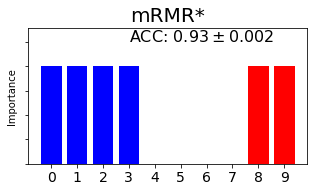

MEtric: [0.35644531 0.34082031 0.33007812 0.24511719 0.27148438]
[1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
Detecting common features: [4 9]
Common feature: 4
Common feature: 9


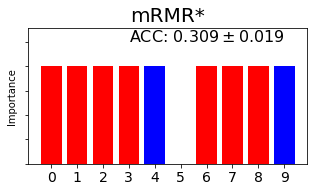

MEtric: [0.26744944 0.26589361 0.26494648 0.26175918 0.2949365 ]
[1. 1. 1. 1. 0. 0. 1. 0. 0. 1.]
Detecting common features: [0 2 3 9]
Common feature: 0
Common feature: 2
Common feature: 3
Common feature: 9


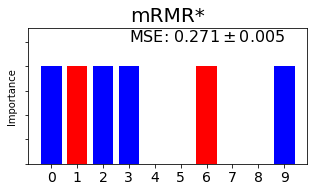

In [10]:
rs.save_graphic_importances("MRMR","orange_skin")
rs.save_graphic_importances("MRMR","XOR")
rs.save_graphic_importances("MRMR","regression")

linear
Ours_(s=5)
MEtric: [0.14336559 0.10457531 0.10979613 0.09946924 0.10448082]
[0.02891025 0.01494294 0.04836795 0.02531624 0.01955253 0.00816068
 0.         0.         0.         0.        ]
Detecting common features: [2 3 4]
Common feature: 2
Common feature: 3
Common feature: 4


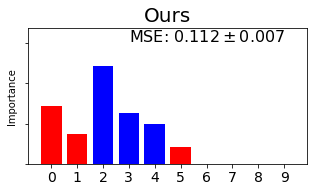

linear
CCM
MEtric: []
[1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
Detecting common features: [0 1 2 3 4 5 6 8]
Common feature: 0
Common feature: 1
Common feature: 2
Common feature: 3
Common feature: 4
Common feature: 5
Common feature: 6
Common feature: 8


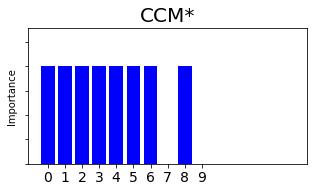

linear
BAHSIC
linear
RFE
MEtric: []
[1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0.]
Detecting common features: [0 1 2 3 4 7 9]
Common feature: 0
Common feature: 1
Common feature: 2
Common feature: 3
Common feature: 4
Common feature: 7
Common feature: 9


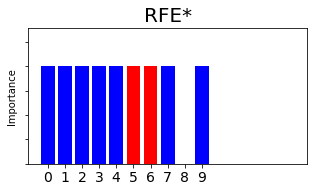

linear
AvGrad
MEtric: [0.07347268 0.06129722 0.05903368 0.06229512 0.07304889]
[0.38507175 0.27948624 0.28976965 0.26135537 0.2588761  0.25644594
 0.20193136 0.18106975 0.         0.2550165  0.         0.21137568
 0.         0.         0.        ]
Detecting common features: [0 1 2 3 4 5]
Common feature: 0
Common feature: 1
Common feature: 2
Common feature: 3
Common feature: 4
Common feature: 5


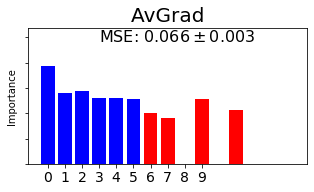

linear
DFS
MEtric: [0.0128191  0.01310374 0.01222292 0.01279592 0.01362716]
[0.07163255 0.06530429 0.0699105  0.06677456 0.06648919 0.05844625
 0.06182395 0.05791185 0.05007094 0.         0.         0.
 0.         0.         0.        ]
Detecting common features: [0 1 2 3 4 5 7]
Common feature: 0
Common feature: 1
Common feature: 2
Common feature: 3
Common feature: 4
Common feature: 5
Common feature: 7


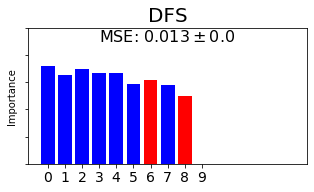

linear
RF
MEtric: [0.73947542 0.74355465 0.74601393 0.76346557 0.73230819]
[0.31571766 0.22603521 0.06554853 0.04731838 0.05498318 0.
 0.04998    0.         0.05558883 0.05236696 0.04942509 0.
 0.         0.         0.        ]
Detecting common features: [ 0  1  2  4  6 10]
Common feature: 0
Common feature: 1
Common feature: 2
Common feature: 4
Common feature: 6
Common feature: 10


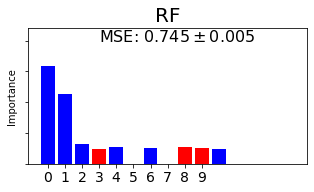

linear
LASSO
MEtric: []
[0.30597259 0.34934082 0.27480534 0.2496843  0.23460059 0.20089673
 0.20090609 0.1725797  0.         0.         0.         0.
 0.         0.         0.        ]
Detecting common features: [0 1 2 3 4 5 6 7]
Common feature: 0
Common feature: 1
Common feature: 2
Common feature: 3
Common feature: 4
Common feature: 5
Common feature: 6
Common feature: 7


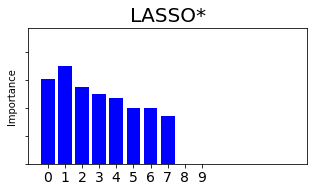

linear
FS
MEtric: []
[8.         8.         4.8        2.8        4.8        2.
 5.         1.66666667 1.66666667 2.6        2.4        1.6
 0.         0.         0.        ]


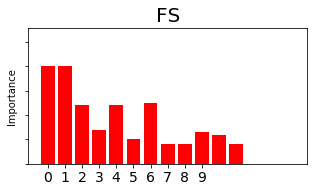

linear
MRMR
linear
Ours_(s=7)
linear
Ours_(s=9)
linear
Ours_(s=8)
MEtric: [0.09165482 0.09158713 0.07975019 0.08984106 0.08548811]
[0.         0.05310382 0.03990579 0.01925091 0.02554257 0.00255589
 0.01593619 0.00224429 0.         0.00183046 0.00258974 0.
 0.         0.         0.        ]
Detecting common features: [1 2 3 4 5 6 7]
Common feature: 1
Common feature: 2
Common feature: 3
Common feature: 4
Common feature: 5
Common feature: 6
Common feature: 7


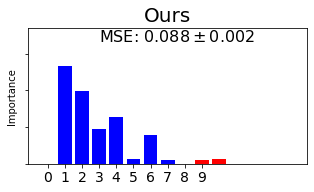

linear
Ours_(s=4)
linear
Ours_(s=6)
regression
Ours_(s=5)
MEtric: [0.15339802 0.16970174 0.17020974 0.16225468 0.15996599]
[ 0.09268785 -0.04948946  0.0404181   0.24100134  0.          0.
 -0.07836093  0.         -0.0816792  -0.08222039]
Detecting common features: [0 1 2 3]
Common feature: 0
Common feature: 1
Common feature: 2
Common feature: 3


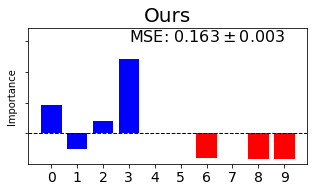

regression
CCM
MEtric: [0.2598055  0.26325643 0.25784493 0.25339654 0.24695636]
[1. 1. 1. 1. 1. 0. 0. 0. 1. 0.]
Detecting common features: [0 1 2 3]
Common feature: 0
Common feature: 1
Common feature: 2
Common feature: 3


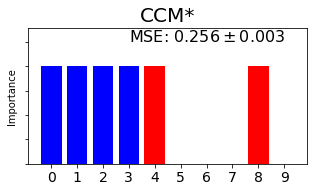

regression
BAHSIC
MEtric: [0.29960562 0.3022082  0.30333314 0.29054995 0.30027461]
[4.8        0.         3.4        3.8        2.         0.
 1.66666667 0.         1.         1.        ]
Detecting common features: [0 2 3]
Common feature: 0
Common feature: 2
Common feature: 3


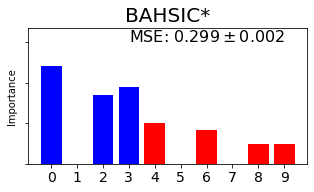

regression
RFE
MEtric: [0.2890209  0.26645588 0.26976078 0.27384178 0.25709637]
[3. 2. 4. 5. 1. 0. 0. 1. 0. 0.]
Detecting common features: [0 1 2 3]
Common feature: 0
Common feature: 1
Common feature: 2
Common feature: 3


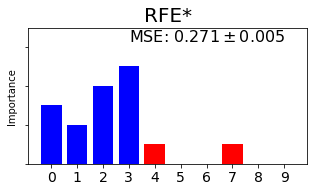

regression
AvGrad
MEtric: [0.35962957 0.41236163 0.35998769 0.3810524  0.39091784]
[0.78490937 0.3338402  0.38130954 0.61566335 0.2555237  0.28419432
 0.3007996  0.32527554 0.29473504 0.        ]
Detecting common features: [0 3]
Common feature: 0
Common feature: 3


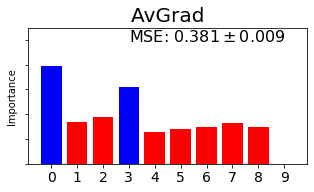

regression
DFS
MEtric: [0.16806326 0.15649955 0.17779848 0.19801093 0.17444076]
[0.27929363 0.21909226 0.1325264  0.17202613 0.         0.18417948
 0.         0.15018658 0.         0.13586059]
Detecting common features: [0 3]
Common feature: 0
Common feature: 3


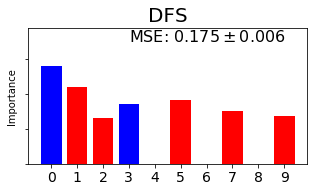

regression
RF
MEtric: [0.79085936 0.78411572 0.77438766 0.7882477  0.79084377]
[0.23660329 0.03469788 0.16185631 0.46609495 0.01681189 0.02037106
 0.         0.0224549  0.0178026  0.02050566]
Detecting common features: [0 1 2 3]
Common feature: 0
Common feature: 1
Common feature: 2
Common feature: 3


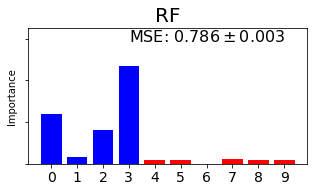

regression
LASSO
MEtric: [0.87498031 0.90621201 0.90521878 0.88480091 0.90566879]
[0.         0.14018996 0.31574205 0.         0.02376343 0.01990295
 0.         0.03122789 0.         0.01647723]
Detecting common features: [1 2 7]
Common feature: 1
Common feature: 2
Common feature: 7


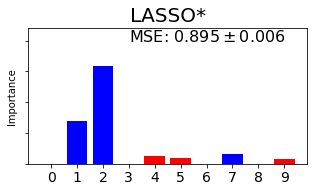

regression
FS
MEtric: [0.173775   0.17007634 0.18024147 0.16467578 0.16977204]
[4. 2. 3. 5. 1. 1. 1. 0. 0. 1.]
Detecting common features: [0 1 2 3]
Common feature: 0
Common feature: 1
Common feature: 2
Common feature: 3


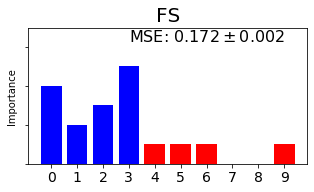

regression
MRMR
MEtric: [0.26744944 0.26589361 0.26494648 0.26175918 0.2949365 ]
[1. 1. 1. 1. 0. 0. 1. 0. 0. 1.]
Detecting common features: [0 2 3 9]
Common feature: 0
Common feature: 2
Common feature: 3
Common feature: 9


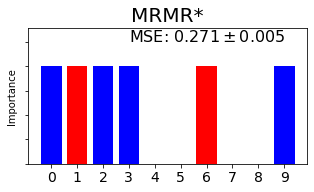

regression
Ours_(s=7)
regression
Ours_(s=9)
regression
Ours_(s=8)
regression
Ours_(s=4)
regression
Ours_(s=6)
XOR
Ours_(s=5)
MEtric: [0.58203125 0.5625     0.5673828  0.58203125 0.56640625]
[ 0.16911264  0.179362    0.15606217  0.         -0.09845831 -0.08667611
  0.         -0.08341857 -0.08751608 -0.08972406]
Detecting common features: [0 1 2]
Common feature: 0
Common feature: 1
Common feature: 2


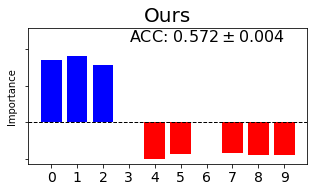

XOR
CCM
MEtric: [0.56640625 0.54785156 0.55664062 0.56152344 0.55175781]
[1. 1. 1. 0. 1. 0. 1. 0. 1. 1.]
Detecting common features: [0 1 2]
Common feature: 0
Common feature: 1
Common feature: 2


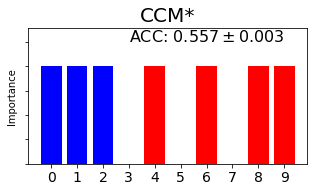

XOR
BAHSIC
MEtric: [0.56640625 0.55957031 0.56933594 0.55371094 0.53613281]
[3.2 4.2 4.6 0.  0.  1.  1.2 0.  0.  2. ]
Detecting common features: [0 1 2 6]
Common feature: 0
Common feature: 1
Common feature: 2
Common feature: 6


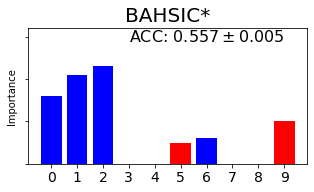

XOR
RFE
MEtric: [0.54492188 0.55957031 0.55078125 0.56054688 0.55078125]
[3.6 4.8 3.6 0.  2.  1.  1.  0.  1.  1. ]
Detecting common features: [0 1 2 4]
Common feature: 0
Common feature: 1
Common feature: 2
Common feature: 4


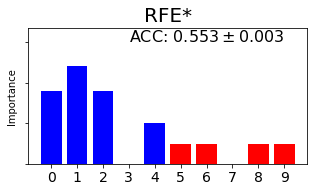

XOR
AvGrad
MEtric: [0.47070312 0.42089844 0.4609375  0.44238281 0.45410156]
[8.3397147e-08 7.8225384e-08 7.6394784e-08 7.0429969e-08 6.6634797e-08
 7.0996222e-08 7.2149270e-08 7.6447648e-08 6.5633287e-08 0.0000000e+00]
Detecting common features: 0


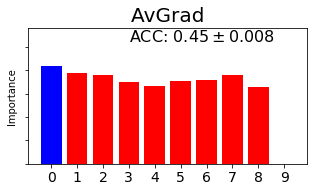

XOR
DFS
MEtric: [0.47753906 0.46777344 0.45507812 0.45996094 0.46777344]
[0.3563469  0.3431649  0.35601318 0.         0.29888713 0.3118063
 0.30493554 0.3383238  0.35547903 0.        ]
Detecting common features: [0 1 2]
Common feature: 0
Common feature: 1
Common feature: 2


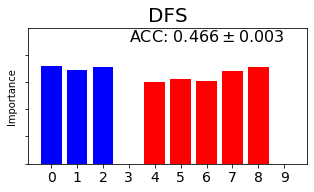

XOR
RF
MEtric: [0.41308594 0.40820312 0.39550781 0.38769531 0.38183594]
[0.12006404 0.12371455 0.12076252 0.         0.10380156 0.09520497
 0.09381038 0.         0.         0.09102262]
Detecting common features: [0 1 2 4]
Common feature: 0
Common feature: 1
Common feature: 2
Common feature: 4


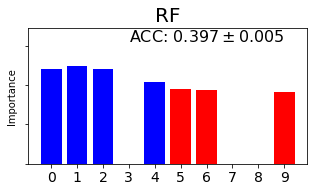

XOR
LASSO
MEtric: [0.23535156 0.3544922  0.27734375 0.26171875 0.34960938]
[ 0.01265426  0.02424309 -0.00313419  0.          0.          0.
  0.          0.          0.00060216  0.        ]
Detecting common features: 8


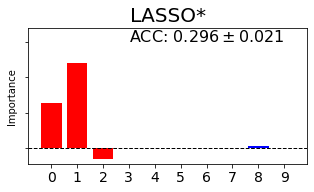

XOR
FS
MEtric: [0.5595703  0.52441406 0.24121094 0.5371094  0.5566406 ]
[2.8  3.5  2.25 5.   1.   3.   2.   1.   2.   0.  ]
Detecting common features: [0 3]
Common feature: 0
Common feature: 3


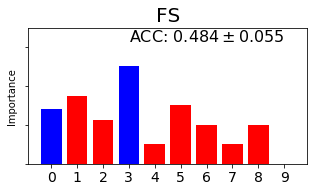

XOR
MRMR
MEtric: [0.35644531 0.34082031 0.33007812 0.24511719 0.27148438]
[1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
Detecting common features: [4 9]
Common feature: 4
Common feature: 9


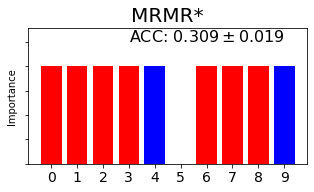

XOR
Ours_(s=7)
XOR
Ours_(s=9)
XOR
Ours_(s=8)
XOR
Ours_(s=4)
XOR
Ours_(s=6)
orange_skin
Ours_(s=5)
MEtric: [0.9160156 0.8935547 0.8984375 0.8955078 0.9042969]
[ 0.0658      0.05251577  0.09311441  0.01899393  0.         -0.03374614
 -0.06464536  0.          0.         -0.04081855]
Detecting common features: [0 1 2 3]
Common feature: 0
Common feature: 1
Common feature: 2
Common feature: 3


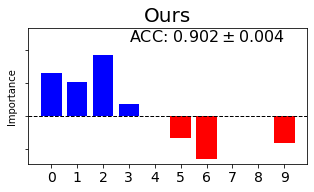

orange_skin
CCM
MEtric: [0.92675781 0.93261719 0.92480469 0.92773438 0.92578125]
[1. 1. 1. 1. 1. 0. 1. 0. 0. 0.]
Detecting common features: [0 1 2 3]
Common feature: 0
Common feature: 1
Common feature: 2
Common feature: 3


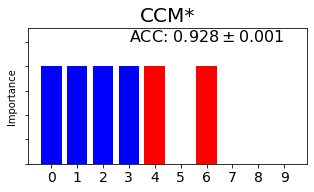

orange_skin
BAHSIC
MEtric: [0.92773438 0.92773438 0.93359375 0.93066406 0.93554688]
[3.6 3.4 4.8 2.2 0.  1.  0.  1.  0.  0. ]
Detecting common features: [0 1 2 3]
Common feature: 0
Common feature: 1
Common feature: 2
Common feature: 3


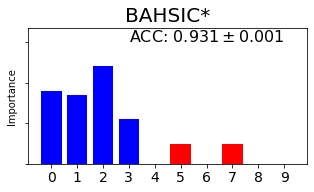

orange_skin
RFE
MEtric: [0.93945312 0.94140625 0.93164062 0.93359375 0.9296875 ]
[3.8 3.2 5.  2.  0.  0.  0.  0.  0.  1. ]
Detecting common features: [0 1 2 3 9]
Common feature: 0
Common feature: 1
Common feature: 2
Common feature: 3
Common feature: 9


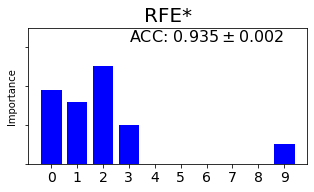

orange_skin
AvGrad
MEtric: [0.80761719 0.828125   0.80566406 0.78320312 0.81347656]
[0.15471488 0.15823008 0.16384165 0.14353743 0.         0.11130569
 0.         0.06904998 0.05753192 0.14110734]
Detecting common features: [1 2]
Common feature: 1
Common feature: 2


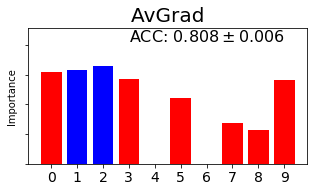

orange_skin
DFS
MEtric: [0.859375   0.84960938 0.82324219 0.83300781 0.82910156]
[0.2778344  0.26422447 0.2915499  0.27349395 0.         0.
 0.         0.17586207 0.         0.2569864 ]
Detecting common features: [0 1 2 3]
Common feature: 0
Common feature: 1
Common feature: 2
Common feature: 3


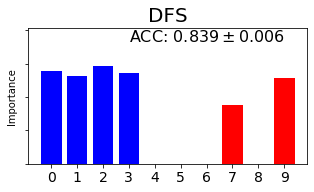

orange_skin
RF
MEtric: [0.88183594 0.87109375 0.85546875 0.87304688 0.86914062]
[0.19098612 0.16766836 0.23880563 0.14160746 0.         0.
 0.04753625 0.         0.05493557 0.0572822 ]
Detecting common features: [0 1 2 3]
Common feature: 0
Common feature: 1
Common feature: 2
Common feature: 3


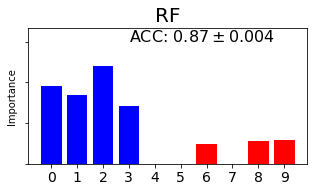

orange_skin
LASSO
MEtric: [0.6279297  0.5644531  0.61035156 0.7451172  0.875     ]
[0.00479382 0.01429942 0.00138267 0.01447376 0.         0.
 0.         0.         0.00380607 0.        ]
Detecting common features: 8


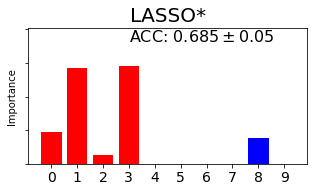

orange_skin
FS
MEtric: [0.421875   0.421875   0.40039062 0.40820312 0.41601562]
[3.8 2.8 5.  2.4 1.  0.  0.  0.  1.  0. ]
Detecting common features: [0 1 2 3]
Common feature: 0
Common feature: 1
Common feature: 2
Common feature: 3


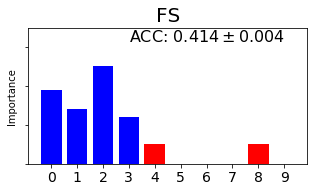

orange_skin
MRMR
MEtric: [0.93457031 0.93066406 0.93652344 0.92578125 0.92382812]
[1. 1. 1. 1. 0. 0. 0. 0. 1. 1.]
Detecting common features: [0 1 2 3]
Common feature: 0
Common feature: 1
Common feature: 2
Common feature: 3


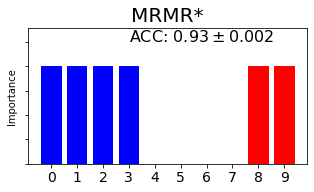

orange_skin
Ours_(s=7)
orange_skin
Ours_(s=9)
orange_skin
Ours_(s=8)
orange_skin
Ours_(s=4)
orange_skin
Ours_(s=6)
MEtric: [0.91308594 0.9003906  0.89160156 0.9160156  0.90722656]
[ 0.08920363  0.07107425  0.12065144  0.02438702 -0.05389999 -0.05935408
 -0.05787781 -0.05812943  0.         -0.05394754]
Detecting common features: [0 1 2 3]
Common feature: 0
Common feature: 1
Common feature: 2
Common feature: 3


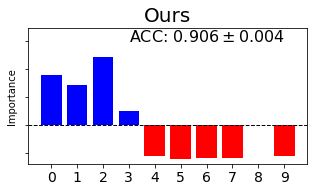

In [55]:
rs.redraw_all()

Getting importances from: [array([2, 0, 3, 1, 9]), array([2, 1, 0, 3, 9]), array([2, 0, 1, 3, 9]), array([2, 3, 0, 1, 8]), array([2, 1, 0, 3, 8])]
Updated importances: [[1. 1. 1. 1. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 0. 0. 0. 0. 1. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 1. 0.]]
Updated masks: [[1. 1. 1. 1. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 0. 0. 0. 0. 1. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 1. 0.]]
MEtric: []
[1. 1. 1. 1. 0. 0. 0. 0. 1. 1.]
Detecting common features: [0 1 2 3]
Common feature: 0
Common feature: 1
Common feature: 2
Common feature: 3


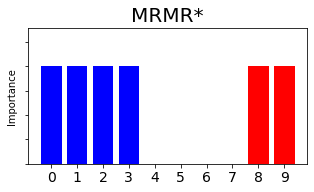

In [24]:
import pandas as pd
import pymrmr

mrmr_best_features=[]
for i in indices:
    X_tr = X[i[0]]
    y_tr = (y[i[0]])
    if(dataset_type=="orange_skin" or dataset_type=="XOR"):
        y_tr = y_tr[:,None]
    elif(dataset_type=="regression"):
        bins = np.arange(np.min(y_tr),np.max(y_tr),(np.max(y_tr)-np.min(y_tr))/10)
        y_tr = np.digitize(y_tr,bins=bins)[:,None]
    df = pd.DataFrame(data=np.hstack((y_tr,X_tr)), columns=[str(i-1) for i in range(data_size+1)])
    features = pymrmr.mRMR(df, 'MIQ', unmasked_data_size)
    mrmr_best_features.append(np.array([df.columns.get_loc(c)-1 for c in features if c in df]))
rs.update("MRMR",dataset_type,features=mrmr_best_features )






[2 1 0 3 4]
[2 0 3 1 6]
[3 0 1 2 4]
[0 2 3 1 4]
[3 2 0 1 4]
[array([2, 1, 0, 3, 4]), array([2, 0, 3, 1, 6]), array([3, 0, 1, 2, 4]), array([0, 2, 3, 1, 4]), array([3, 2, 0, 1, 4])]
Getting importances from: [array([2, 1, 0, 3, 4]), array([2, 0, 3, 1, 6]), array([3, 0, 1, 2, 4]), array([0, 2, 3, 1, 4]), array([3, 2, 0, 1, 4])]
[[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]]
Getting importances from: [array([2, 1, 0, 3, 4]), array([2, 0, 3, 1, 6]), array([3, 0, 1, 2, 4]), array([0, 2, 3, 1, 4]), array([3, 2, 0, 1, 4])]
Updated importances: [[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]]
Updated masks: [[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0

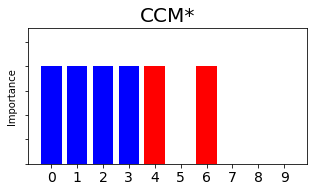

In [25]:
ccm_best_features=[]
for i in indices:
    X_tr = X[i[0]]
    X_val = X[i[1]]
    y_tr = y[i[0]]
    y_val = y[i[1]]
    epsilon = 0.001; num_features = unmasked_data_size; type_Y = 'real-valued'
    if(dataset_type=="XOR"): type_Y = "categorical"
    elif(dataset_type=="orange_skin"): type_Y = "binary"
    rank = ccm.ccm(X_tr, y_tr, num_features, type_Y, epsilon, iterations = 100, verbose = False)
    ccm_best_features.append(np.argsort(rank)[:num_features])
    print(ccm_best_features[-1])
print(ccm_best_features)
ccm_importances = ResultSaver.get_importances_from_feature_set(ccm_best_features)
print(ccm_importances)
#print(get_feature_set_from_importances(ccm_importances,unmasked_data_size))
#save_graphic_importances(ccm_importances,"CCM",metric=None)  
rs.update("CCM",dataset_type,imp=None,perf=None,mask=None,features =ccm_best_features )

In [49]:
if(dataset_type=='XOR'):
    y = get_one_hot(y.astype(np.int8),4)
    y_te = get_one_hot(y_te.astype(np.int8),4)
elif(dataset_type=='orange_skin'):
    y = ((y+1)/2.0)#.astype(np.int8)
    y_te = ((y_te+1)/2.0)#.astype(np.int8)
elif(dataset_type=='regression'):
    y_te = ((y_te-np.mean(y))/np.std(y))#.astype(np.int8)
    y = ((y-np.mean(y))/np.std(y))#.astype(np.int8)
print(y.shape)
print(y[0:5])
print(y_te[0:5])


(512,)
[1. 0. 0. 1. 0.]
[1. 0. 1. 0. 1.]


In [8]:
tf.set_random_seed(0)
sn_features = []
sn_importances = []
on_metrics = []
sn_masks=[]
for i in indices:
    X_tr = X[i[0]]
    X_val = X[i[1]]
    y_tr = y[i[0]]
    y_val = y[i[1]]
    K.clear_session()
    fs = FeatureSelector(data_shape,unmasked_data_size,data_batch_size,mask_batch_size,str_id = "Synth"+dataset_type)
    FeatureSelector.clear_networks()
    if(dataset_type=="linear" or dataset_type=="regression"):
        fs.create_dense_objnet([100,50,25,1], "linear",None) # for linear
    elif (dataset_type=="orange_skin"):
        fs.create_dense_objnet([60,30,20,1], "sigmoid",metrics=[keras.metrics.BinaryAccuracy()],error_func=K.binary_crossentropy)
    elif (dataset_type=="XOR"):
        fs.create_dense_objnet([60,30,15,4], "softmax",metrics=[keras.metrics.CategoricalAccuracy()],error_func=K.categorical_crossentropy)
    fs.objnet.set_early_stopping_params(6000,patience_batches=600,minimize=True)
    fs.create_dense_subnet([100,50,10,1])
    fs.create_mask_optimizer(epoch_condition=6000,perturbation_size=pert_size,use_new_optimization=True)
    fs.create_data_generator(None) 
    fs.train_networks_on_data(X_tr,y_tr,15000,val_data=(X_val,y_val),lr=0.5)
    # 6000 for regression, 4000 for orange skin
    mask_halves = np.ones(shape = (data_size))[None,:]/2
    features_opt_used = np.squeeze(np.argwhere(fs.mopt.get_opt_mask(unmasked_data_size,fs.subnet.model,None,None,12)==1))
    m_best_used_features = np.zeros((1,data_size))
    m_best_used_features[0,features_opt_used] = 1
    print("Detected b features: "+str(features_opt_used))
    grad_used_opt = -MaskOptimizer.gradient(fs.subnet.model,m_best_used_features)[0][0,:]
    sn_importances.append(grad_used_opt)
    sn_masks.append(m_best_used_features)
    fs.test_networks_on_data(X_te,y_te,m_best_used_features)
    on_metrics.append(fs.objnet.te_loss_history[-1])
on_metrics=np.array(on_metrics)
sn_importances=np.array(sn_importances)
sn_masks=np.array(sn_masks)
#if(dataset_type=="orange_skin" or dataset_type=="XOR"):
#    rs.update("Ours_(s="+str(unmasked_data_size)+")",dataset_type,imp=sn_importances,perf=on_metrics[:,1],mask=sn_masks )
#else:
#    rs.update("Ours_(s="+str(unmasked_data_size)+")",dataset_type,imp=sn_importances,perf=on_metrics,mask=sn_masks )
if(dataset_type=="linear"):
    sn_best_features = np.array([np.nonzero(sn_masks[i])[1] for i in range(5)])


Creating objnet model
Using masks with input value: 0
Object network model built:
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 10)           0           input_1[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 10)           0           input_2[0][0]                    
____________

Subject Network model built:
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               1100      
_________________________________________________________________
dense_5 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 6,671
Trainable params: 6,671
Non-trainable params: 0
____________________________

KeyboardInterrupt: 

In [ ]:
print(on_metrics)
print(np.mean(on_metrics,axis=0))

Updated importances: [[ 0.0863045   0.04411276  0.09778841  0.02594844 -0.06369362 -0.06434822
  -0.06006707 -0.0632676  -0.06442107 -0.04896432]
 [ 0.04512995  0.04793508  0.06642768  0.01176597 -0.03331227 -0.03374614
  -0.03272551 -0.03277148 -0.0353651  -0.03480358]
 [ 0.07350588  0.05543677  0.09707084  0.02501808 -0.04500318 -0.04338857
  -0.04146261 -0.04162172 -0.04053077 -0.0352828 ]
 [ 0.05669964  0.06317486  0.11206756  0.03094449 -0.06992838 -0.06646088
  -0.06464536 -0.07292851 -0.06835891 -0.06431179]
 [ 0.06736006  0.0519194   0.09221756  0.00129267 -0.04146112 -0.03945989
  -0.04331486 -0.03938149 -0.04193831 -0.03820851]]
Updated masks: [[[1. 1. 1. 1. 0. 0. 0. 0. 0. 1.]]

 [[1. 1. 1. 1. 0. 1. 0. 0. 0. 0.]]

 [[1. 1. 1. 1. 0. 0. 0. 0. 0. 1.]]

 [[1. 1. 1. 1. 0. 0. 1. 0. 0. 0.]]

 [[1. 1. 1. 1. 0. 0. 0. 0. 0. 1.]]]
MEtric: [0.9160156 0.8935547 0.8984375 0.8955078 0.9042969]
[ 0.0658      0.05251577  0.09311441  0.01899393  0.         -0.03374614
 -0.06464536  0.         

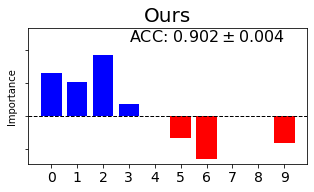

In [12]:
if(dataset_type=="orange_skin" or dataset_type=="XOR"):
    rs.update("Ours_(s="+str(unmasked_data_size)+")",dataset_type,imp=sn_importances,perf=on_metrics[:,1],mask=sn_masks )
else:
    rs.update("Ours_(s="+str(unmasked_data_size)+")",dataset_type,imp=sn_importances,perf=on_metrics,mask=sn_masks )

In [12]:
print(rs.methods["DFS"])
print(rs.performances[rs.datasets["regression"]][rs.methods["Ours_(s="+str(unmasked_data_size)+")"]])
print(rs.performances[rs.datasets["orange_skin"]][rs.methods["Ours_(s="+str(unmasked_data_size)+")"]])
print(rs.performances[rs.datasets["XOR"]][rs.methods["Ours_(s="+str(unmasked_data_size)+")"]])
#print(rs.importances[rs.datasets["XOR"]][rs.methods["DFS"]])

5
[0.15339802 0.16970174 0.17020974 0.16225468 0.15996599]
[0.92871094 0.9296875  0.9042969  0.91308594 0.9111328 ]
[0.58203125 0.5625     0.5673828  0.58203125 0.56640625]


0
[0 1 2 3 9]
Used m_opt: [0 1 2 3 9]
Feature ranking from m_opt  gradients: [0 1 2 3 9]
[1 2 3 9]
[0 2 3 9]
[0 1 3 9]
[0 1 2 9]
[0 1 2 3 4 9]
[0 1 2 3 5 9]
[0 1 2 3 6 9]
[0 1 2 3 7 9]
[0 1 2 3 8 9]
[0 1 2 3]


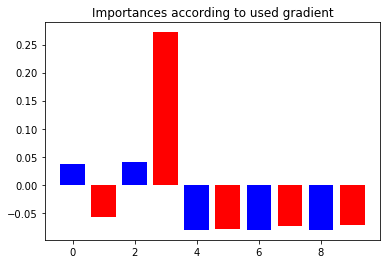

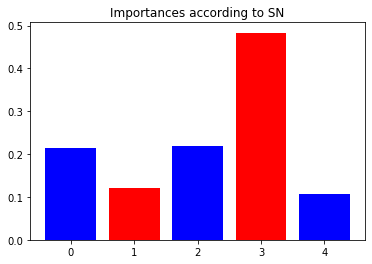

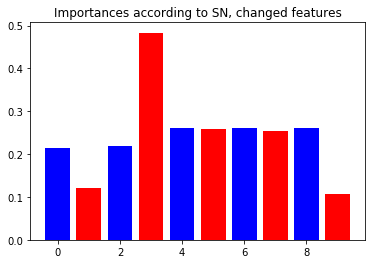

In [259]:


#importances = fs.get_most_important_features(1,1)
#sorted_features = np.argsort(importances)
#best_features = sorted_features[-unmasked_data_size:]
#print("Feature ranking from simple gradients: "+str(best_features))
mask_halves = np.ones(shape = (data_size))[None,:]/2

#m_best_features = np.zeros((1,data_size))
#m_best_features[0,best_features] = 1
features_opt_used = np.squeeze(np.argwhere(fs.mopt.get_opt_mask(unmasked_data_size,fs.subnet.model,None,None,12)==1))
m_best_used_features = np.zeros((1,data_size))
m_best_used_features[0,features_opt_used] = 1
print("Used m_opt: "+str(features_opt_used))
#grad_opt = -MaskOptimizer.gradient(fs.subnet.model,m_best_features)[0][0,:]
grad_halves = -MaskOptimizer.gradient(fs.subnet.model,mask_halves)[0][0,:]
grad_used_opt = -MaskOptimizer.gradient(fs.subnet.model,m_best_used_features)[0][0,:]

#features_ranking = np.argsort(grad_used_opt)
#best_features=features_ranking[-unmasked_data_size:]
best_features = features_opt_used
print("Feature ranking from m_opt  gradients: "+str(best_features))

least_important_feature = np.argmin(grad_used_opt)
repeated_features = np.tile(best_features,(len(best_features),1))
features_lacking_least = np.zeros((unmasked_data_size,unmasked_data_size-1)).astype(np.int8)
for i in range(len(best_features)):
    features_lacking_least[i] = np.delete(repeated_features[i],i)
features_with_channged_one = np.zeros((unmasked_data_size,unmasked_data_size)).astype(np.int8)
for i in range(len(best_features)):
    features_with_channged_one[i,:-1] =features_lacking_least[i]
    features_with_channged_one[i,-1] =least_important_feature

masks_with_lacking_least = np.zeros((unmasked_data_size,data_size))
masks_without_one_feature = np.zeros((data_size,data_size))
for i in range(unmasked_data_size):
    masks_with_lacking_least[i,features_lacking_least[i]] = 1.0
for i in range(data_size):
    masks_without_one_feature[i,best_features] = 1.0
    masks_without_one_feature[i,i] = int(not bool(masks_without_one_feature[i,i]))
    print(np.squeeze(np.argwhere(masks_without_one_feature[i,:]==1)))

importances_lacking_one = fs.subnet.model.predict(masks_with_lacking_least)
importances_changed_one = fs.subnet.model.predict(masks_without_one_feature)


colours = ["blue","red"]*12+["blue"]

plt.title("Importances according to used gradient")
plt.bar(x_range,grad_used_opt,color=colours)
plt.show()
if(dataset_type=="linear"):
    importances_true = [evaluate_subset_by_linear_reg(feature_set,X_tr,y_tr,X_te,y_te)[1] for feature_set in features_lacking_least]
    importances_true_tr = [evaluate_subset_by_linear_reg(feature_set,X_tr,y_tr,X_tr,y_tr)[0] for feature_set in features_lacking_least]
    print(importances_true)
    print(importances_true_tr)
    plt.title("Importances according to train data")
    plt.bar(np.arange(unmasked_data_size),importances_true_tr,color=colours)
    plt.show()
plt.title("Importances according to SN")
plt.bar(np.arange(unmasked_data_size),np.squeeze(importances_lacking_one),color=colours)
plt.show()
plt.title("Importances according to SN, changed features")
plt.bar(np.arange(data_size),np.squeeze(importances_changed_one),color=colours)
plt.show()


In [13]:
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
rf_best_features=[]
rf_metrics=[]
rf_importances=[]
for i in indices:
    X_tr = X[i[0]]
    X_val = X[i[1]]
    y_tr = (y[i[0]])
    y_val = (y[i[1]])
    if(dataset_type=="XOR"):    
        y_tr = np.nonzero(y_tr)[1]
        y_val = np.nonzero(y_val)[1]
    best_args = None
    best_test_mse = 10000000
    if(dataset_type=="XOR" or dataset_type=="orange_skin"):    
        best_test_mse = 0
    for n_estimators in range(50,180,10):
        for max_depth in range(8,16,1):
            if(dataset_type=="linear" or dataset_type=="regression"):
                model = RandomForestRegressor(n_estimators = n_estimators,max_depth=max_depth,n_jobs=1)
            elif(dataset_type=="XOR" or dataset_type=="orange_skin"):    
                model = RandomForestClassifier(n_estimators = n_estimators,max_depth=max_depth,n_jobs=1)
            model = model.fit(X_tr, y_tr)
            mse_val = model.score(X_val,y_val)
            #print(str([n_estimators,max_depth])+" "+str(mse_val))
            if(dataset_type=="XOR" or dataset_type=="orange_skin"):    
                if(mse_val > best_test_mse):
                    best_args = [n_estimators,max_depth]
                    best_test_mse = mse_val
            else:
                if(mse_val < best_test_mse):
                    best_args = [n_estimators,max_depth]
                    best_test_mse = mse_val
    
    if(dataset_type=="linear" or dataset_type=="regression"):
        model = RandomForestRegressor(n_estimators=best_args[0],max_depth=best_args[1])
    elif(dataset_type=="XOR" or dataset_type=="orange_skin"):    
        model = RandomForestClassifier(n_estimators=best_args[0],max_depth=best_args[1])
    model = model.fit(X_tr, y_tr)
    #y_pred = model.predict(X_tr)
    mse_tr =  model.score(X_tr,y_tr)
    print(mse_tr)
    rf_importance = model.feature_importances_  
    #y_pred = model.predict(X_te)
    if(dataset_type=="XOR"):    
        mse_te =  model.score(X_te,np.nonzero(y_te)[1])
    else:
        mse_te =  model.score(X_te,y_te)
    rf_metrics.append(mse_te)
    print(mse_te)

    #print(str(importances)+" train mse: "+str(mse_tr)+" test mse: "+str(mse_te))
    print("Optimal hyperparameters: "+str(best_args))
    rf_best_features.append(np.argsort(rf_importance)[-unmasked_data_size:])
    print(rf_best_features[-1])
    rf_importances.append(rf_importance)
print(rf_best_features)
print(rf_metrics)
rf_importances = np.array(rf_importances)
rs.update("RF",dataset_type,imp=rf_importances,perf=np.array(rf_metrics) )


1.0
0.4091796875
Optimal hyperparameters: [80, 14]
[6 4 1 0 2]
1.0
0.3857421875
Optimal hyperparameters: [70, 11]
[3 4 2 1 0]
1.0
0.4208984375
Optimal hyperparameters: [90, 15]
[6 4 2 0 1]
1.0
0.3740234375
Optimal hyperparameters: [150, 14]
[8 4 2 1 0]
1.0
0.3583984375
Optimal hyperparameters: [150, 12]
[5 4 2 0 1]
[array([6, 4, 1, 0, 2]), array([3, 4, 2, 1, 0]), array([6, 4, 2, 0, 1]), array([8, 4, 2, 1, 0]), array([5, 4, 2, 0, 1])]
[0.4091796875, 0.3857421875, 0.4208984375, 0.3740234375, 0.3583984375]


NameError: name 'rs' is not defined

In [50]:
from sklearn.linear_model import ElasticNet,Lasso
lasso_best_features = []
lasso_metrics = []
lasso_importances = []
for i in indices:
    X_tr = X[i[0]]
    X_val = X[i[1]]
    y_tr = y[i[0]]
    y_val = y[i[1]]
    best_args = None
    best_test_mse = 10000000
    for alpha in np.arange(0.0,1.0,0.001):
        model = Lasso(alpha)
        model = model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        mse_te = np.mean((y_pred-y_val)*(y_pred-y_val))
        #mse_te = model.score(X_val,y_val)
        if(mse_te < best_test_mse):
            best_args = [alpha]
            best_test_mse = mse_te
                

    model = Lasso(best_args[0])
    model = model.fit(X_tr, y_tr)
    y_pred = model.predict(X_tr)
    mse_tr = np.mean((y_pred-y_tr)*(y_pred-y_tr))
    lasso_imp = model.coef_  
    y_pred = model.predict(X_te)
    mse_te = np.mean((y_pred-y_te)*(y_pred-y_te))
    print(str(lasso_imp)+" train mse: "+str(mse_tr)+" test mse: "+str(mse_te))
    #print(np.argsort(lasso_imp))
    print(best_args)
    #plt.bar(np.arange(len(lasso_importances)),lasso_importances)
    #plt.show()
    lasso_best_features.append(np.argsort(lasso_imp)[-unmasked_data_size:])
    #print(lasso_best_features[-1])
    lasso_importances.append(np.array(lasso_imp))
print(lasso_importances)
rs.update("LASSO",dataset_type,imp=np.array(lasso_importances) )


/home/mbcxwmw3/miniconda2/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/home/mbcxwmw3/miniconda2/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/mbcxwmw3/miniconda2/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50.086280837148394, tolerance: 0.010224938875305623
  positive)


[ 0.00000000e+00  2.62640161e-02  1.00882129e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.52685291e-05
  2.66872118e-03 -0.00000000e+00] train mse: 0.2473097102667878 test mse: 0.2503867511029284
[0.025]


/home/mbcxwmw3/miniconda2/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/home/mbcxwmw3/miniconda2/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/mbcxwmw3/miniconda2/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.447875412781066, tolerance: 0.010224938875305623
  positive)


[ 0.          0.00816778  0.          0.         -0.         -0.
 -0.          0.          0.         -0.        ] train mse: 0.24871682893934738 test mse: 0.24987953412319605
[0.07100000000000001]


/home/mbcxwmw3/miniconda2/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/home/mbcxwmw3/miniconda2/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/mbcxwmw3/miniconda2/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.319504654331254, tolerance: 0.01025
  positive)


[ 0.          0.00352914  0.          0.          0.         -0.
 -0.         -0.          0.         -0.        ] train mse: 0.24940602188022262 test mse: 0.24991934428663376
[0.081]


/home/mbcxwmw3/miniconda2/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/home/mbcxwmw3/miniconda2/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/mbcxwmw3/miniconda2/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.86786739086172, tolerance: 0.01025
  positive)


[ 0.          0.02102379  0.          0.00576    -0.         -0.
  0.         -0.          0.00984895 -0.0306392 ] train mse: 0.24542541598592 test mse: 0.25015659967897697
[0.02]


/home/mbcxwmw3/miniconda2/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/home/mbcxwmw3/miniconda2/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/mbcxwmw3/miniconda2/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.760818596059835, tolerance: 0.01025
  positive)


[-0.          0.00713423 -0.          0.         -0.          0.
  0.          0.          0.00475324 -0.01231402] train mse: 0.2478605749900631 test mse: 0.24963841312899138
[0.039]
[array([ 0.00000000e+00,  2.62640161e-02,  1.00882129e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -2.52685291e-05,
        2.66872118e-03, -0.00000000e+00]), array([ 0.        ,  0.00816778,  0.        ,  0.        , -0.        ,
       -0.        , -0.        ,  0.        ,  0.        , -0.        ]), array([ 0.        ,  0.00352914,  0.        ,  0.        ,  0.        ,
       -0.        , -0.        , -0.        ,  0.        , -0.        ]), array([ 0.        ,  0.02102379,  0.        ,  0.00576   , -0.        ,
       -0.        ,  0.        , -0.        ,  0.00984895, -0.0306392 ]), array([-0.        ,  0.00713423, -0.        ,  0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.00475324, -0.01231402])]


NameError: name 'rs' is not defined

In [14]:
from DFS import CreateDFS,getImportancesFromDFS
dfs_importances = []
dfs_metrics = []
for lambda1 in [0.001,0.005,0.01,0.05]:
    for i in indices:
        X_tr = X[i[0]]
        X_val = X[i[1]]
        y_tr = y[i[0]]
        y_val = y[i[1]]
        K.clear_session()
        inp = Input((data_size))
        x = Dense(50,activation='tanh')(inp)
        x = Dense(25,activation='tanh')(x)
        x = Dense(10,activation='tanh')(x)
        if(dataset_type=="linear" or dataset_type=="regression"):x = Dense(1,activation='linear')(x)
        elif (dataset_type=="orange_skin"):x = Dense(1,activation='sigmoid')(x)
        elif (dataset_type=="XOR"):x = Dense(4,activation='softmax')(x)
        mod = Model(inputs=inp,outputs=x)
        mod_new = CreateDFS(mod,lambda1,1.0,0.0001,0)
        #mod_new.compile(optimizer='adam',loss='acc')
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
        if(dataset_type=="linear" or dataset_type=="regression"):
            mod_new.compile(optimizer='adam',loss='mse')
            mod_new.fit(X_tr,y_tr,batch_size=32,epochs=1000,validation_data=(X_val,y_val),validation_freq=1,callbacks=[callback],verbose=0)
        elif (dataset_type=="orange_skin"):
            mod_new.compile(optimizer='adam',loss=K.binary_crossentropy,metrics=[keras.metrics.BinaryAccuracy()])
            mod_new.fit(X_tr,y_tr,batch_size=32,epochs=1000,validation_data=(X_val,y_val),validation_freq=1,callbacks=[callback],verbose=0)

        elif (dataset_type=="XOR"):
            mod_new.compile(optimizer='adam',loss=K.categorical_crossentropy,metrics=[keras.metrics.CategoricalAccuracy()])
            mod_new.fit(X_tr,y_tr,batch_size=32,epochs=1000,validation_data=(X_val,y_val),validation_freq=1,callbacks=[callback],verbose=0)
        print(str(lambda1)+": "+str(mod_new.evaluate(X_te,y_te)))



10
1024/1024 [==============================] - 0s 37us/sample - loss: 0.6888 - binary_accuracy: 0.7842
0.001: [0.68878907058388, 0.7841797]
10
1024/1024 [==============================] - 0s 49us/sample - loss: 0.4802 - binary_accuracy: 0.8018
0.001: [0.48023550608195364, 0.8017578]
10
1024/1024 [==============================] - 0s 56us/sample - loss: 0.6336 - binary_accuracy: 0.7939
0.001: [0.6335682272911072, 0.7939453]
10
1024/1024 [==============================] - 0s 54us/sample - loss: 0.4307 - binary_accuracy: 0.8574
0.001: [0.4306839043274522, 0.8574219]
10
1024/1024 [==============================] - 0s 29us/sample - loss: 0.7025 - binary_accuracy: 0.5156
0.001: [0.702458493411541, 0.515625]
10
1024/1024 [==============================] - 0s 57us/sample - loss: 0.7088 - binary_accuracy: 0.8018
0.005: [0.708794767037034, 0.8017578]
10
1024/1024 [==============================] - 0s 41us/sample - loss: 0.5120 - binary_accuracy: 0.8506
0.005: [0.5120485352817923, 0.85058594]
10

1024/1024 [==============================] - 0s 36us/sample - loss: 0.6555 - binary_accuracy: 0.8018
0.005: [0.6555302231572568, 0.8017578]
10
1024/1024 [==============================] - 0s 29us/sample - loss: 0.6915 - binary_accuracy: 0.6377
0.005: [0.6915420070290565, 0.6376953]
10
1024/1024 [==============================] - 0s 30us/sample - loss: 0.5315 - binary_accuracy: 0.8330
0.005: [0.5314853151794523, 0.8330078]
10
1024/1024 [==============================] - 0s 49us/sample - loss: 0.6439 - binary_accuracy: 0.7422
0.01: [0.6439262311905622, 0.7421875]
10
1024/1024 [==============================] - 0s 57us/sample - loss: 0.4331 - binary_accuracy: 0.8594
0.01: [0.4331085290759802, 0.859375]
10
1024/1024 [==============================] - 0s 38us/sample - loss: 0.6316 - binary_accuracy: 0.7988
0.01: [0.6316126571036875, 0.7988281]
10
1024/1024 [==============================] - 0s 47us/sample - loss: 0.5912 - binary_accuracy: 0.8242
0.01: [0.5911735999397933, 0.82421875]
10
102

1024/1024 [==============================] - 0s 55us/sample - loss: 0.7096 - binary_accuracy: 0.7832
0.05: [0.7096155397593975, 0.7832031]
10
1024/1024 [==============================] - 0s 48us/sample - loss: 0.5874 - binary_accuracy: 0.8135
0.05: [0.5874113130848855, 0.81347656]
10
1024/1024 [==============================] - 0s 54us/sample - loss: 0.7024 - binary_accuracy: 0.6523
0.05: [0.7024300871416926, 0.65234375]
10
1024/1024 [==============================] - 0s 37us/sample - loss: 0.6966 - binary_accuracy: 0.5127
0.05: [0.696644127368927, 0.5126953]
10
1024/1024 [==============================] - 0s 43us/sample - loss: 0.5617 - binary_accuracy: 0.7373
0.05: [0.5616630036383867, 0.7373047]


10
Train on 409 samples, validate on 103 samples
Epoch 1/700
409/409 [==============================] - 0s 576us/sample - loss: 0.6948 - binary_accuracy: 0.3985
Epoch 2/700
409/409 [==============================] - 0s 136us/sample - loss: 0.6933 - binary_accuracy: 0.4572
Epoch 3/700
409/409 [==============================] - 0s 69us/sample - loss: 0.6929 - binary_accuracy: 0.5037
Epoch 4/700
409/409 [==============================] - 0s 114us/sample - loss: 0.6911 - binary_accuracy: 0.5012
Epoch 5/700
409/409 [==============================] - 0s 105us/sample - loss: 0.6895 - binary_accuracy: 0.5428
Epoch 6/700
409/409 [==============================] - 0s 95us/sample - loss: 0.6882 - binary_accuracy: 0.5232
Epoch 7/700
409/409 [==============================] - 0s 79us/sample - loss: 0.6858 - binary_accuracy: 0.5599
Epoch 8/700
409/409 [==============================] - 0s 91us/sample - loss: 0.6865 - binary_accuracy: 0.5672
Epoch 9/700
409/409 [==============================] - 0s 8

409/409 [==============================] - 0s 78us/sample - loss: 0.5587 - binary_accuracy: 0.7237
Epoch 135/700
409/409 [==============================] - 0s 63us/sample - loss: 0.5598 - binary_accuracy: 0.7262
Epoch 136/700
409/409 [==============================] - 0s 58us/sample - loss: 0.5533 - binary_accuracy: 0.7335
Epoch 137/700
409/409 [==============================] - 0s 78us/sample - loss: 0.5522 - binary_accuracy: 0.7335
Epoch 138/700
409/409 [==============================] - 0s 75us/sample - loss: 0.5515 - binary_accuracy: 0.7335
Epoch 139/700
409/409 [==============================] - 0s 69us/sample - loss: 0.5480 - binary_accuracy: 0.7262
Epoch 140/700
409/409 [==============================] - 0s 82us/sample - loss: 0.5469 - binary_accuracy: 0.7286 - val_loss: 0.6681 - val_binary_accuracy: 0.6602
Epoch 141/700
409/409 [==============================] - 0s 73us/sample - loss: 0.5446 - binary_accuracy: 0.7262
Epoch 142/700
409/409 [==============================] - 0s 6

409/409 [==============================] - 0s 78us/sample - loss: 0.1828 - binary_accuracy: 0.9389
Epoch 276/700
409/409 [==============================] - 0s 88us/sample - loss: 0.1805 - binary_accuracy: 0.9413
Epoch 277/700
409/409 [==============================] - 0s 76us/sample - loss: 0.1787 - binary_accuracy: 0.9487
Epoch 278/700
409/409 [==============================] - 0s 107us/sample - loss: 0.1781 - binary_accuracy: 0.9438
Epoch 279/700
409/409 [==============================] - 0s 54us/sample - loss: 0.1763 - binary_accuracy: 0.9462
Epoch 280/700
409/409 [==============================] - 0s 67us/sample - loss: 0.1759 - binary_accuracy: 0.9389 - val_loss: 0.5046 - val_binary_accuracy: 0.7961
Epoch 281/700
409/409 [==============================] - 0s 76us/sample - loss: 0.1736 - binary_accuracy: 0.9438
Epoch 282/700
409/409 [==============================] - 0s 62us/sample - loss: 0.1707 - binary_accuracy: 0.9487
Epoch 283/700
409/409 [==============================] - 0s 

409/409 [==============================] - 0s 53us/sample - loss: 0.0445 - binary_accuracy: 0.9951
Epoch 417/700
409/409 [==============================] - 0s 63us/sample - loss: 0.0445 - binary_accuracy: 0.9951
Epoch 418/700
409/409 [==============================] - 0s 55us/sample - loss: 0.0437 - binary_accuracy: 0.9951
Epoch 419/700
409/409 [==============================] - 0s 56us/sample - loss: 0.0437 - binary_accuracy: 0.9951
Epoch 420/700
409/409 [==============================] - 0s 61us/sample - loss: 0.0438 - binary_accuracy: 0.9951 - val_loss: 0.4337 - val_binary_accuracy: 0.8252
Epoch 421/700
409/409 [==============================] - 0s 54us/sample - loss: 0.0431 - binary_accuracy: 0.9951
Epoch 422/700
409/409 [==============================] - 0s 58us/sample - loss: 0.0424 - binary_accuracy: 0.9951
Epoch 423/700
409/409 [==============================] - 0s 57us/sample - loss: 0.0421 - binary_accuracy: 0.9951
Epoch 424/700
409/409 [==============================] - 0s 5

409/409 [==============================] - 0s 76us/sample - loss: 0.0127 - binary_accuracy: 1.0000
Epoch 558/700
409/409 [==============================] - 0s 91us/sample - loss: 0.0126 - binary_accuracy: 1.0000
Epoch 559/700
409/409 [==============================] - 0s 89us/sample - loss: 0.0125 - binary_accuracy: 1.0000
Epoch 560/700
409/409 [==============================] - 0s 127us/sample - loss: 0.0125 - binary_accuracy: 1.0000 - val_loss: 0.4967 - val_binary_accuracy: 0.8641
Epoch 561/700
409/409 [==============================] - 0s 84us/sample - loss: 0.0123 - binary_accuracy: 1.0000
Epoch 562/700
409/409 [==============================] - 0s 101us/sample - loss: 0.0123 - binary_accuracy: 1.0000
Epoch 563/700
409/409 [==============================] - 0s 91us/sample - loss: 0.0122 - binary_accuracy: 1.0000
Epoch 564/700
409/409 [==============================] - 0s 77us/sample - loss: 0.0121 - binary_accuracy: 1.0000
Epoch 565/700
409/409 [==============================] - 0s

409/409 [==============================] - 0s 55us/sample - loss: 0.0060 - binary_accuracy: 1.0000
Epoch 699/700
409/409 [==============================] - 0s 55us/sample - loss: 0.0060 - binary_accuracy: 1.0000
Epoch 700/700
1024/1024 [==============================] - 0s 24us/sample - loss: 0.6868 - binary_accuracy: 0.8594
10
Train on 409 samples, validate on 103 samples
Epoch 1/700
409/409 [==============================] - 0s 722us/sample - loss: 0.6985 - binary_accuracy: 0.4499
Epoch 2/700
409/409 [==============================] - 0s 128us/sample - loss: 0.6935 - binary_accuracy: 0.5159
Epoch 3/700
409/409 [==============================] - 0s 108us/sample - loss: 0.6918 - binary_accuracy: 0.5208
Epoch 4/700
409/409 [==============================] - 0s 90us/sample - loss: 0.6892 - binary_accuracy: 0.5306
Epoch 5/700
409/409 [==============================] - 0s 120us/sample - loss: 0.6882 - binary_accuracy: 0.5428
Epoch 6/700
409/409 [==============================] - 0s 108us/s

409/409 [==============================] - 0s 61us/sample - loss: 0.6648 - binary_accuracy: 0.5819 - val_loss: 0.7116 - val_binary_accuracy: 0.4757
Epoch 61/700
409/409 [==============================] - 0s 53us/sample - loss: 0.6628 - binary_accuracy: 0.5844
Epoch 62/700
409/409 [==============================] - 0s 54us/sample - loss: 0.6611 - binary_accuracy: 0.5917
Epoch 63/700
409/409 [==============================] - 0s 52us/sample - loss: 0.6599 - binary_accuracy: 0.5795
Epoch 64/700
409/409 [==============================] - 0s 56us/sample - loss: 0.6583 - binary_accuracy: 0.5917
Epoch 65/700
409/409 [==============================] - 0s 73us/sample - loss: 0.6577 - binary_accuracy: 0.5990
Epoch 66/700
409/409 [==============================] - 0s 49us/sample - loss: 0.6543 - binary_accuracy: 0.6015
Epoch 67/700
409/409 [==============================] - 0s 59us/sample - loss: 0.6518 - binary_accuracy: 0.6039
Epoch 68/700
409/409 [==============================] - 0s 59us/samp

409/409 [==============================] - 0s 87us/sample - loss: 0.4642 - binary_accuracy: 0.8142
Epoch 202/700
409/409 [==============================] - 0s 71us/sample - loss: 0.4608 - binary_accuracy: 0.8191
Epoch 203/700
409/409 [==============================] - 0s 59us/sample - loss: 0.4599 - binary_accuracy: 0.8117
Epoch 204/700
409/409 [==============================] - 0s 55us/sample - loss: 0.4590 - binary_accuracy: 0.8142
Epoch 205/700
409/409 [==============================] - 0s 70us/sample - loss: 0.4583 - binary_accuracy: 0.8020
Epoch 206/700
409/409 [==============================] - 0s 59us/sample - loss: 0.4554 - binary_accuracy: 0.8215
Epoch 207/700
409/409 [==============================] - 0s 70us/sample - loss: 0.4544 - binary_accuracy: 0.8093
Epoch 208/700
409/409 [==============================] - 0s 59us/sample - loss: 0.4552 - binary_accuracy: 0.8068
Epoch 209/700
409/409 [==============================] - 0s 59us/sample - loss: 0.4562 - binary_accuracy: 0.79

409/409 [==============================] - 0s 84us/sample - loss: 0.0858 - binary_accuracy: 0.9829
Epoch 343/700
409/409 [==============================] - 0s 106us/sample - loss: 0.0854 - binary_accuracy: 0.9853
Epoch 344/700
409/409 [==============================] - 0s 89us/sample - loss: 0.0832 - binary_accuracy: 0.9829
Epoch 345/700
409/409 [==============================] - 0s 105us/sample - loss: 0.0824 - binary_accuracy: 0.9829
Epoch 346/700
409/409 [==============================] - 0s 118us/sample - loss: 0.0822 - binary_accuracy: 0.9853
Epoch 347/700
409/409 [==============================] - 0s 130us/sample - loss: 0.0809 - binary_accuracy: 0.9829
Epoch 348/700
409/409 [==============================] - 0s 93us/sample - loss: 0.0804 - binary_accuracy: 0.9804
Epoch 349/700
409/409 [==============================] - 0s 86us/sample - loss: 0.0788 - binary_accuracy: 0.9829
Epoch 350/700
409/409 [==============================] - 0s 97us/sample - loss: 0.0796 - binary_accuracy: 

409/409 [==============================] - 0s 67us/sample - loss: 0.0209 - binary_accuracy: 1.0000
Epoch 484/700
409/409 [==============================] - 0s 59us/sample - loss: 0.0210 - binary_accuracy: 1.0000
Epoch 485/700
409/409 [==============================] - 0s 65us/sample - loss: 0.0220 - binary_accuracy: 0.9976
Epoch 486/700
409/409 [==============================] - 0s 60us/sample - loss: 0.0204 - binary_accuracy: 1.0000
Epoch 487/700
409/409 [==============================] - 0s 60us/sample - loss: 0.0203 - binary_accuracy: 1.0000
Epoch 488/700
409/409 [==============================] - 0s 53us/sample - loss: 0.0202 - binary_accuracy: 1.0000
Epoch 489/700
409/409 [==============================] - 0s 53us/sample - loss: 0.0205 - binary_accuracy: 1.0000
Epoch 490/700
409/409 [==============================] - 0s 64us/sample - loss: 0.0203 - binary_accuracy: 1.0000
Epoch 491/700
409/409 [==============================] - 0s 60us/sample - loss: 0.0199 - binary_accuracy: 1.00

409/409 [==============================] - 0s 54us/sample - loss: 0.0095 - binary_accuracy: 1.0000
Epoch 625/700
409/409 [==============================] - 0s 55us/sample - loss: 0.0095 - binary_accuracy: 1.0000
Epoch 626/700
409/409 [==============================] - 0s 60us/sample - loss: 0.0101 - binary_accuracy: 1.0000
Epoch 627/700
409/409 [==============================] - 0s 52us/sample - loss: 0.0095 - binary_accuracy: 1.0000
Epoch 628/700
409/409 [==============================] - 0s 53us/sample - loss: 0.0094 - binary_accuracy: 1.0000
Epoch 629/700
409/409 [==============================] - 0s 60us/sample - loss: 0.0093 - binary_accuracy: 1.0000
Epoch 630/700
409/409 [==============================] - 0s 64us/sample - loss: 0.0092 - binary_accuracy: 1.0000
Epoch 631/700
409/409 [==============================] - 0s 56us/sample - loss: 0.0091 - binary_accuracy: 1.0000
Epoch 632/700
409/409 [==============================] - 0s 54us/sample - loss: 0.0091 - binary_accuracy: 1.00

410/410 [==============================] - 0s 86us/sample - loss: 0.6542 - binary_accuracy: 0.5805
Epoch 58/700
410/410 [==============================] - 0s 78us/sample - loss: 0.6507 - binary_accuracy: 0.5732
Epoch 59/700
410/410 [==============================] - 0s 72us/sample - loss: 0.6467 - binary_accuracy: 0.5854
Epoch 60/700
410/410 [==============================] - 0s 85us/sample - loss: 0.6431 - binary_accuracy: 0.5951 - val_loss: 0.7026 - val_binary_accuracy: 0.5294
Epoch 61/700
410/410 [==============================] - 0s 86us/sample - loss: 0.6391 - binary_accuracy: 0.6098
Epoch 62/700
410/410 [==============================] - 0s 79us/sample - loss: 0.6361 - binary_accuracy: 0.6073
Epoch 63/700
410/410 [==============================] - 0s 76us/sample - loss: 0.6308 - binary_accuracy: 0.6171
Epoch 64/700
410/410 [==============================] - 0s 74us/sample - loss: 0.6296 - binary_accuracy: 0.6195
Epoch 65/700
410/410 [==============================] - 0s 83us/samp

410/410 [==============================] - 0s 88us/sample - loss: 0.5046 - binary_accuracy: 0.7610
Epoch 200/700
410/410 [==============================] - 0s 66us/sample - loss: 0.5042 - binary_accuracy: 0.7634 - val_loss: 0.6976 - val_binary_accuracy: 0.6569
Epoch 201/700
410/410 [==============================] - 0s 55us/sample - loss: 0.5005 - binary_accuracy: 0.7683
Epoch 202/700
410/410 [==============================] - 0s 55us/sample - loss: 0.4988 - binary_accuracy: 0.7756
Epoch 203/700
410/410 [==============================] - 0s 59us/sample - loss: 0.4977 - binary_accuracy: 0.7756
Epoch 204/700
410/410 [==============================] - 0s 56us/sample - loss: 0.4965 - binary_accuracy: 0.7659
Epoch 205/700
410/410 [==============================] - 0s 58us/sample - loss: 0.4968 - binary_accuracy: 0.7780
Epoch 206/700
410/410 [==============================] - 0s 62us/sample - loss: 0.4959 - binary_accuracy: 0.7659
Epoch 207/700
410/410 [==============================] - 0s 5

410/410 [==============================] - 0s 61us/sample - loss: 0.3328 - binary_accuracy: 0.8756 - val_loss: 0.7865 - val_binary_accuracy: 0.6078
Epoch 341/700
410/410 [==============================] - 0s 53us/sample - loss: 0.3322 - binary_accuracy: 0.8780
Epoch 342/700
410/410 [==============================] - 0s 52us/sample - loss: 0.3323 - binary_accuracy: 0.8756
Epoch 343/700
410/410 [==============================] - 0s 59us/sample - loss: 0.3276 - binary_accuracy: 0.8805
Epoch 344/700
410/410 [==============================] - 0s 62us/sample - loss: 0.3258 - binary_accuracy: 0.8780
Epoch 345/700
410/410 [==============================] - 0s 54us/sample - loss: 0.3248 - binary_accuracy: 0.8829
Epoch 346/700
410/410 [==============================] - 0s 53us/sample - loss: 0.3247 - binary_accuracy: 0.8805
Epoch 347/700
410/410 [==============================] - 0s 59us/sample - loss: 0.3206 - binary_accuracy: 0.8780
Epoch 348/700
410/410 [==============================] - 0s 5

Epoch 481/700
410/410 [==============================] - 0s 51us/sample - loss: 0.0740 - binary_accuracy: 0.9927
Epoch 482/700
410/410 [==============================] - 0s 50us/sample - loss: 0.0727 - binary_accuracy: 0.9927
Epoch 483/700
410/410 [==============================] - 0s 66us/sample - loss: 0.0719 - binary_accuracy: 0.9902
Epoch 484/700
410/410 [==============================] - 0s 65us/sample - loss: 0.0706 - binary_accuracy: 0.9927
Epoch 485/700
410/410 [==============================] - 0s 53us/sample - loss: 0.0698 - binary_accuracy: 0.9902
Epoch 486/700
410/410 [==============================] - 0s 57us/sample - loss: 0.0680 - binary_accuracy: 0.9927
Epoch 487/700
410/410 [==============================] - 0s 55us/sample - loss: 0.0674 - binary_accuracy: 0.9951
Epoch 488/700
410/410 [==============================] - 0s 49us/sample - loss: 0.0667 - binary_accuracy: 0.9951
Epoch 489/700
410/410 [==============================] - 0s 49us/sample - loss: 0.0660 - binary_

410/410 [==============================] - 0s 63us/sample - loss: 0.0312 - binary_accuracy: 1.0000
Epoch 553/700
410/410 [==============================] - 0s 65us/sample - loss: 0.0310 - binary_accuracy: 1.0000
Epoch 554/700
410/410 [==============================] - 0s 83us/sample - loss: 0.0305 - binary_accuracy: 1.0000
Epoch 555/700
410/410 [==============================] - 0s 74us/sample - loss: 0.0303 - binary_accuracy: 1.0000
Epoch 556/700
410/410 [==============================] - 0s 70us/sample - loss: 0.0300 - binary_accuracy: 1.0000
Epoch 557/700
410/410 [==============================] - 0s 70us/sample - loss: 0.0297 - binary_accuracy: 1.0000
Epoch 558/700
410/410 [==============================] - 0s 67us/sample - loss: 0.0295 - binary_accuracy: 1.0000
Epoch 559/700
410/410 [==============================] - 0s 68us/sample - loss: 0.0290 - binary_accuracy: 1.0000
Epoch 560/700
410/410 [==============================] - 0s 76us/sample - loss: 0.0292 - binary_accuracy: 1.00

410/410 [==============================] - 0s 59us/sample - loss: 0.0119 - binary_accuracy: 1.0000
Epoch 694/700
410/410 [==============================] - 0s 67us/sample - loss: 0.0118 - binary_accuracy: 1.0000
Epoch 695/700
410/410 [==============================] - 0s 66us/sample - loss: 0.0118 - binary_accuracy: 1.0000
Epoch 696/700
410/410 [==============================] - 0s 60us/sample - loss: 0.0116 - binary_accuracy: 1.0000
Epoch 697/700
410/410 [==============================] - 0s 81us/sample - loss: 0.0117 - binary_accuracy: 1.0000
Epoch 698/700
410/410 [==============================] - 0s 55us/sample - loss: 0.0116 - binary_accuracy: 1.0000
Epoch 699/700
410/410 [==============================] - 0s 75us/sample - loss: 0.0115 - binary_accuracy: 1.0000
Epoch 700/700
1024/1024 [==============================] - 0s 44us/sample - loss: 0.7284 - binary_accuracy: 0.8232
10
Train on 410 samples, validate on 102 samples
Epoch 1/700
410/410 [==============================] - 0s 5

Epoch 55/700
410/410 [==============================] - 0s 77us/sample - loss: 0.6244 - binary_accuracy: 0.6829
Epoch 56/700
410/410 [==============================] - 0s 74us/sample - loss: 0.6223 - binary_accuracy: 0.6585
Epoch 57/700
410/410 [==============================] - 0s 68us/sample - loss: 0.6233 - binary_accuracy: 0.7049
Epoch 58/700
410/410 [==============================] - 0s 64us/sample - loss: 0.6172 - binary_accuracy: 0.6902
Epoch 59/700
410/410 [==============================] - 0s 59us/sample - loss: 0.6154 - binary_accuracy: 0.6854
Epoch 60/700
410/410 [==============================] - 0s 70us/sample - loss: 0.6145 - binary_accuracy: 0.6927 - val_loss: 0.6372 - val_binary_accuracy: 0.6373
Epoch 61/700
410/410 [==============================] - 0s 62us/sample - loss: 0.6106 - binary_accuracy: 0.6902
Epoch 62/700
410/410 [==============================] - 0s 74us/sample - loss: 0.6077 - binary_accuracy: 0.7024
Epoch 63/700
410/410 [==============================] -

410/410 [==============================] - 0s 73us/sample - loss: 0.4143 - binary_accuracy: 0.8122
Epoch 198/700
410/410 [==============================] - 0s 73us/sample - loss: 0.4136 - binary_accuracy: 0.8146
Epoch 199/700
410/410 [==============================] - 0s 71us/sample - loss: 0.4110 - binary_accuracy: 0.8171
Epoch 200/700
410/410 [==============================] - 0s 82us/sample - loss: 0.4105 - binary_accuracy: 0.8195 - val_loss: 0.4493 - val_binary_accuracy: 0.8235
Epoch 201/700
410/410 [==============================] - 0s 58us/sample - loss: 0.4064 - binary_accuracy: 0.8195
Epoch 202/700
410/410 [==============================] - 0s 65us/sample - loss: 0.4073 - binary_accuracy: 0.8171
Epoch 203/700
410/410 [==============================] - 0s 71us/sample - loss: 0.4038 - binary_accuracy: 0.8220
Epoch 204/700
410/410 [==============================] - 0s 83us/sample - loss: 0.4024 - binary_accuracy: 0.8146
Epoch 205/700
410/410 [==============================] - 0s 1

410/410 [==============================] - 0s 67us/sample - loss: 0.1477 - binary_accuracy: 0.9634
Epoch 339/700
410/410 [==============================] - 0s 70us/sample - loss: 0.1463 - binary_accuracy: 0.9683
Epoch 340/700
410/410 [==============================] - 0s 73us/sample - loss: 0.1440 - binary_accuracy: 0.9707 - val_loss: 0.4233 - val_binary_accuracy: 0.8333
Epoch 341/700
410/410 [==============================] - 0s 68us/sample - loss: 0.1431 - binary_accuracy: 0.9683
Epoch 342/700
410/410 [==============================] - 0s 63us/sample - loss: 0.1414 - binary_accuracy: 0.9659
Epoch 343/700
410/410 [==============================] - 0s 68us/sample - loss: 0.1396 - binary_accuracy: 0.9659
Epoch 344/700
410/410 [==============================] - 0s 61us/sample - loss: 0.1374 - binary_accuracy: 0.9659
Epoch 345/700
410/410 [==============================] - 0s 61us/sample - loss: 0.1357 - binary_accuracy: 0.9707
Epoch 346/700
410/410 [==============================] - 0s 5

410/410 [==============================] - 0s 86us/sample - loss: 0.0273 - binary_accuracy: 1.0000
Epoch 480/700
410/410 [==============================] - 0s 112us/sample - loss: 0.0271 - binary_accuracy: 1.0000 - val_loss: 0.5923 - val_binary_accuracy: 0.8627
Epoch 481/700
410/410 [==============================] - 0s 71us/sample - loss: 0.0270 - binary_accuracy: 1.0000
Epoch 482/700
410/410 [==============================] - 0s 101us/sample - loss: 0.0270 - binary_accuracy: 1.0000
Epoch 483/700
410/410 [==============================] - 0s 93us/sample - loss: 0.0266 - binary_accuracy: 1.0000
Epoch 484/700
410/410 [==============================] - 0s 58us/sample - loss: 0.0260 - binary_accuracy: 1.0000
Epoch 485/700
410/410 [==============================] - 0s 66us/sample - loss: 0.0258 - binary_accuracy: 1.0000
Epoch 486/700
410/410 [==============================] - 0s 77us/sample - loss: 0.0253 - binary_accuracy: 1.0000
Epoch 487/700
410/410 [==============================] - 0s

410/410 [==============================] - 0s 61us/sample - loss: 0.0106 - binary_accuracy: 1.0000 - val_loss: 0.7617 - val_binary_accuracy: 0.8529
Epoch 621/700
410/410 [==============================] - 0s 52us/sample - loss: 0.0106 - binary_accuracy: 1.0000
Epoch 622/700
410/410 [==============================] - 0s 53us/sample - loss: 0.0105 - binary_accuracy: 1.0000
Epoch 623/700
410/410 [==============================] - 0s 54us/sample - loss: 0.0105 - binary_accuracy: 1.0000
Epoch 624/700
410/410 [==============================] - 0s 61us/sample - loss: 0.0105 - binary_accuracy: 1.0000
Epoch 625/700
410/410 [==============================] - 0s 63us/sample - loss: 0.0104 - binary_accuracy: 1.0000
Epoch 626/700
410/410 [==============================] - 0s 52us/sample - loss: 0.0104 - binary_accuracy: 1.0000
Epoch 627/700
410/410 [==============================] - 0s 52us/sample - loss: 0.0103 - binary_accuracy: 1.0000
Epoch 628/700
410/410 [==============================] - 0s 6

410/410 [==============================] - 0s 61us/sample - loss: 0.6750 - binary_accuracy: 0.5512
Epoch 53/700
410/410 [==============================] - 0s 68us/sample - loss: 0.6739 - binary_accuracy: 0.5732
Epoch 54/700
410/410 [==============================] - 0s 74us/sample - loss: 0.6672 - binary_accuracy: 0.5854
Epoch 55/700
410/410 [==============================] - 0s 77us/sample - loss: 0.6636 - binary_accuracy: 0.5927
Epoch 56/700
410/410 [==============================] - 0s 92us/sample - loss: 0.6597 - binary_accuracy: 0.6073
Epoch 57/700
410/410 [==============================] - 0s 85us/sample - loss: 0.6562 - binary_accuracy: 0.6195
Epoch 58/700
410/410 [==============================] - 0s 90us/sample - loss: 0.6524 - binary_accuracy: 0.6122
Epoch 59/700
410/410 [==============================] - 0s 66us/sample - loss: 0.6485 - binary_accuracy: 0.6268
Epoch 60/700
410/410 [==============================] - 0s 90us/sample - loss: 0.6452 - binary_accuracy: 0.6415 - val

410/410 [==============================] - 0s 67us/sample - loss: 0.3623 - binary_accuracy: 0.8439
Epoch 195/700
410/410 [==============================] - 0s 57us/sample - loss: 0.3602 - binary_accuracy: 0.8439
Epoch 196/700
410/410 [==============================] - 0s 55us/sample - loss: 0.3608 - binary_accuracy: 0.8415
Epoch 197/700
410/410 [==============================] - 0s 73us/sample - loss: 0.3595 - binary_accuracy: 0.8463
Epoch 198/700
410/410 [==============================] - 0s 55us/sample - loss: 0.3581 - binary_accuracy: 0.8463
Epoch 199/700
410/410 [==============================] - 0s 54us/sample - loss: 0.3566 - binary_accuracy: 0.8439
Epoch 200/700
410/410 [==============================] - 0s 67us/sample - loss: 0.3566 - binary_accuracy: 0.8488 - val_loss: 0.6120 - val_binary_accuracy: 0.7255
Epoch 201/700
410/410 [==============================] - 0s 65us/sample - loss: 0.3556 - binary_accuracy: 0.8415
Epoch 202/700
410/410 [==============================] - 0s 9

410/410 [==============================] - 0s 74us/sample - loss: 0.0738 - binary_accuracy: 0.9902
Epoch 336/700
410/410 [==============================] - 0s 66us/sample - loss: 0.0734 - binary_accuracy: 0.9902
Epoch 337/700
410/410 [==============================] - 0s 56us/sample - loss: 0.0705 - binary_accuracy: 0.9902
Epoch 338/700
410/410 [==============================] - 0s 57us/sample - loss: 0.0710 - binary_accuracy: 0.9902
Epoch 339/700
410/410 [==============================] - 0s 76us/sample - loss: 0.0698 - binary_accuracy: 0.9902
Epoch 340/700
410/410 [==============================] - 0s 67us/sample - loss: 0.0683 - binary_accuracy: 0.9902 - val_loss: 0.4942 - val_binary_accuracy: 0.8235
Epoch 341/700
410/410 [==============================] - 0s 65us/sample - loss: 0.0678 - binary_accuracy: 0.9902
Epoch 342/700
410/410 [==============================] - 0s 95us/sample - loss: 0.0671 - binary_accuracy: 0.9902
Epoch 343/700
410/410 [==============================] - 0s 8

410/410 [==============================] - 0s 63us/sample - loss: 0.0146 - binary_accuracy: 1.0000
Epoch 477/700
410/410 [==============================] - 0s 60us/sample - loss: 0.0144 - binary_accuracy: 1.0000
Epoch 478/700
410/410 [==============================] - 0s 57us/sample - loss: 0.0143 - binary_accuracy: 1.0000
Epoch 479/700
410/410 [==============================] - 0s 54us/sample - loss: 0.0144 - binary_accuracy: 1.0000
Epoch 480/700
410/410 [==============================] - 0s 72us/sample - loss: 0.0142 - binary_accuracy: 1.0000 - val_loss: 0.7054 - val_binary_accuracy: 0.8137
Epoch 481/700
410/410 [==============================] - 0s 57us/sample - loss: 0.0141 - binary_accuracy: 1.0000
Epoch 482/700
410/410 [==============================] - 0s 65us/sample - loss: 0.0140 - binary_accuracy: 1.0000
Epoch 483/700
410/410 [==============================] - 0s 56us/sample - loss: 0.0139 - binary_accuracy: 1.0000
Epoch 484/700
410/410 [==============================] - 0s 6

410/410 [==============================] - 0s 75us/sample - loss: 0.0069 - binary_accuracy: 1.0000
Epoch 618/700
410/410 [==============================] - 0s 71us/sample - loss: 0.0068 - binary_accuracy: 1.0000
Epoch 619/700
410/410 [==============================] - 0s 91us/sample - loss: 0.0068 - binary_accuracy: 1.0000
Epoch 620/700
410/410 [==============================] - 0s 102us/sample - loss: 0.0068 - binary_accuracy: 1.0000 - val_loss: 0.8848 - val_binary_accuracy: 0.8137
Epoch 621/700
410/410 [==============================] - 0s 85us/sample - loss: 0.0068 - binary_accuracy: 1.0000
Epoch 622/700
410/410 [==============================] - 0s 68us/sample - loss: 0.0068 - binary_accuracy: 1.0000
Epoch 623/700
410/410 [==============================] - 0s 95us/sample - loss: 0.0067 - binary_accuracy: 1.0000
Epoch 624/700
410/410 [==============================] - 0s 60us/sample - loss: 0.0066 - binary_accuracy: 1.0000
Epoch 625/700
410/410 [==============================] - 0s 

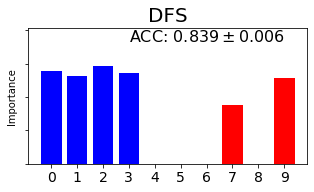

In [29]:
from DFS import CreateDFS,getImportancesFromDFS
dfs_importances = []
dfs_metrics = []
for i in indices:
    X_tr = X[i[0]]
    X_val = X[i[1]]
    y_tr = y[i[0]]
    y_val = y[i[1]]
    K.clear_session()
    inp = Input((data_size))
    x = Dense(50,activation='tanh')(inp)
    x = Dense(25,activation='tanh')(x)
    x = Dense(10,activation='tanh')(x)
    if(dataset_type=="linear" or dataset_type=="regression"):x = Dense(1,activation='linear')(x)
    elif (dataset_type=="orange_skin"):x = Dense(1,activation='sigmoid')(x)
    elif (dataset_type=="XOR"):x = Dense(4,activation='softmax')(x)
    mod = Model(inputs=inp,outputs=x)
    mod_new = CreateDFS(mod,0.01,1.0,0.0001,0)
    #mod_new.compile(optimizer='adam',loss='acc')
    if(dataset_type=="linear" or dataset_type=="regression"):
        mod_new.compile(optimizer='adam',loss='mse')
        mod_new.fit(X_tr,y_tr,batch_size=32,epochs=400,validation_data=(X_val,y_val),validation_freq=20)
    elif (dataset_type=="orange_skin"):
        mod_new.compile(optimizer='adam',loss=K.binary_crossentropy,metrics=[keras.metrics.BinaryAccuracy()])
        mod_new.fit(X_tr,y_tr,batch_size=32,epochs=700,validation_data=(X_val,y_val),validation_freq=20)

    elif (dataset_type=="XOR"):
        mod_new.compile(optimizer='adam',loss=K.categorical_crossentropy,metrics=[keras.metrics.CategoricalAccuracy()])
        mod_new.fit(X_tr,y_tr,batch_size=32,epochs=1000,validation_data=(X_val,y_val),validation_freq=20)
    dfs_importances.append(np.abs(getImportancesFromDFS(mod_new)))
    dfs_metrics.append(mod_new.evaluate(X_te,y_te))

dfs_metrics = np.array(dfs_metrics)
dfs_best_features = ResultSaver.get_feature_set_from_importances(dfs_importances,n_top=unmasked_data_size)
#dfs_masks = np.array([np.squeeze(get_boolean_mask(f)) for f in dfs_features])
#if(dataset_type=="regression" or dataset_type=="linear"):
#    save_graphic_importances(np.array(dfs_importances),"DFS",metric=dfs_metrics,plot_label="MSE",masks=dfs_masks)  
#else:
#    save_graphic_importances(np.array(dfs_importances),"DFS",metric=dfs_metrics[:,1],masks=dfs_masks)  
if(dataset_type=="orange_skin" or dataset_type=="XOR"):
    rs.update("DFS",dataset_type,imp=dfs_importances,perf=dfs_metrics[:,1] )
else:
    rs.update("DFS",dataset_type,imp=dfs_importances,perf=dfs_metrics )


Train on 409 samples, validate on 103 samples
Epoch 1/540
409/409 [==============================] - 0s 577us/sample - loss: 0.7110 - binary_accuracy: 0.5061
Epoch 2/540
409/409 [==============================] - 0s 92us/sample - loss: 0.6905 - binary_accuracy: 0.5281
Epoch 3/540
409/409 [==============================] - 0s 110us/sample - loss: 0.6800 - binary_accuracy: 0.5770
Epoch 4/540
409/409 [==============================] - 0s 87us/sample - loss: 0.6756 - binary_accuracy: 0.5892
Epoch 5/540
409/409 [==============================] - 0s 83us/sample - loss: 0.6717 - binary_accuracy: 0.5892
Epoch 6/540
409/409 [==============================] - 0s 110us/sample - loss: 0.6696 - binary_accuracy: 0.5892
Epoch 7/540
409/409 [==============================] - 0s 116us/sample - loss: 0.6660 - binary_accuracy: 0.5990
Epoch 8/540
409/409 [==============================] - 0s 102us/sample - loss: 0.6627 - binary_accuracy: 0.6039
Epoch 9/540
409/409 [==============================] - 0s 66u

409/409 [==============================] - 0s 71us/sample - loss: 0.0081 - binary_accuracy: 1.0000
Epoch 144/540
409/409 [==============================] - 0s 83us/sample - loss: 0.0079 - binary_accuracy: 1.0000
Epoch 145/540
409/409 [==============================] - 0s 89us/sample - loss: 0.0078 - binary_accuracy: 1.0000
Epoch 146/540
409/409 [==============================] - 0s 69us/sample - loss: 0.0075 - binary_accuracy: 1.0000
Epoch 147/540
409/409 [==============================] - 0s 61us/sample - loss: 0.0074 - binary_accuracy: 1.0000
Epoch 148/540
409/409 [==============================] - 0s 63us/sample - loss: 0.0072 - binary_accuracy: 1.0000
Epoch 149/540
409/409 [==============================] - 0s 60us/sample - loss: 0.0070 - binary_accuracy: 1.0000
Epoch 150/540
409/409 [==============================] - 0s 56us/sample - loss: 0.0068 - binary_accuracy: 1.0000
Epoch 151/540
409/409 [==============================] - 0s 65us/sample - loss: 0.0067 - binary_accuracy: 1.00

409/409 [==============================] - 0s 55us/sample - loss: 8.7405e-04 - binary_accuracy: 1.0000
Epoch 285/540
409/409 [==============================] - 0s 85us/sample - loss: 8.6105e-04 - binary_accuracy: 1.0000
Epoch 286/540
409/409 [==============================] - 0s 55us/sample - loss: 8.5177e-04 - binary_accuracy: 1.0000
Epoch 287/540
409/409 [==============================] - 0s 78us/sample - loss: 8.4055e-04 - binary_accuracy: 1.0000
Epoch 288/540
409/409 [==============================] - 0s 54us/sample - loss: 8.3999e-04 - binary_accuracy: 1.0000
Epoch 289/540
409/409 [==============================] - 0s 57us/sample - loss: 8.2262e-04 - binary_accuracy: 1.0000
Epoch 290/540
409/409 [==============================] - 0s 51us/sample - loss: 8.1451e-04 - binary_accuracy: 1.0000
Epoch 291/540
409/409 [==============================] - 0s 47us/sample - loss: 8.0343e-04 - binary_accuracy: 1.0000
Epoch 292/540
409/409 [==============================] - 0s 54us/sample - loss

409/409 [==============================] - 0s 72us/sample - loss: 2.2328e-04 - binary_accuracy: 1.0000 - val_loss: 1.2878 - val_binary_accuracy: 0.7864
Epoch 421/540
409/409 [==============================] - 0s 59us/sample - loss: 2.2114e-04 - binary_accuracy: 1.0000
Epoch 422/540
409/409 [==============================] - 0s 56us/sample - loss: 2.2073e-04 - binary_accuracy: 1.0000
Epoch 423/540
409/409 [==============================] - 0s 60us/sample - loss: 2.1706e-04 - binary_accuracy: 1.0000
Epoch 424/540
409/409 [==============================] - 0s 52us/sample - loss: 2.1549e-04 - binary_accuracy: 1.0000
Epoch 425/540
409/409 [==============================] - 0s 62us/sample - loss: 2.1377e-04 - binary_accuracy: 1.0000
Epoch 426/540
409/409 [==============================] - 0s 62us/sample - loss: 2.1186e-04 - binary_accuracy: 1.0000
Epoch 427/540
409/409 [==============================] - 0s 64us/sample - loss: 2.1014e-04 - binary_accuracy: 1.0000
Epoch 428/540
409/409 [======

409/409 [==============================] - 0s 86us/sample - loss: 0.6081 - binary_accuracy: 0.6797
Epoch 17/540
409/409 [==============================] - 0s 79us/sample - loss: 0.6025 - binary_accuracy: 0.6822
Epoch 18/540
409/409 [==============================] - 0s 108us/sample - loss: 0.5979 - binary_accuracy: 0.6968
Epoch 19/540
409/409 [==============================] - 0s 76us/sample - loss: 0.5908 - binary_accuracy: 0.6993
Epoch 20/540
409/409 [==============================] - 0s 298us/sample - loss: 0.5852 - binary_accuracy: 0.7066 - val_loss: 0.6897 - val_binary_accuracy: 0.5437
Epoch 21/540
409/409 [==============================] - 0s 76us/sample - loss: 0.5782 - binary_accuracy: 0.7213
Epoch 22/540
409/409 [==============================] - 0s 70us/sample - loss: 0.5740 - binary_accuracy: 0.7213
Epoch 23/540
409/409 [==============================] - 0s 67us/sample - loss: 0.5637 - binary_accuracy: 0.7408
Epoch 24/540
409/409 [==============================] - 0s 56us/sa

409/409 [==============================] - 0s 76us/sample - loss: 0.0104 - binary_accuracy: 1.0000
Epoch 158/540
409/409 [==============================] - 0s 52us/sample - loss: 0.0100 - binary_accuracy: 1.0000
Epoch 159/540
409/409 [==============================] - 0s 54us/sample - loss: 0.0098 - binary_accuracy: 1.0000
Epoch 160/540
409/409 [==============================] - 0s 79us/sample - loss: 0.0096 - binary_accuracy: 1.0000 - val_loss: 0.7628 - val_binary_accuracy: 0.8155
Epoch 161/540
409/409 [==============================] - 0s 68us/sample - loss: 0.0094 - binary_accuracy: 1.0000
Epoch 162/540
409/409 [==============================] - 0s 117us/sample - loss: 0.0093 - binary_accuracy: 1.0000
Epoch 163/540
409/409 [==============================] - 0s 53us/sample - loss: 0.0091 - binary_accuracy: 1.0000
Epoch 164/540
409/409 [==============================] - 0s 59us/sample - loss: 0.0090 - binary_accuracy: 1.0000
Epoch 165/540
409/409 [==============================] - 0s 

409/409 [==============================] - 0s 58us/sample - loss: 0.0012 - binary_accuracy: 1.0000
Epoch 299/540
409/409 [==============================] - 0s 60us/sample - loss: 0.0012 - binary_accuracy: 1.0000
Epoch 300/540
409/409 [==============================] - 0s 62us/sample - loss: 0.0012 - binary_accuracy: 1.0000 - val_loss: 1.0081 - val_binary_accuracy: 0.8155
Epoch 301/540
409/409 [==============================] - 0s 50us/sample - loss: 0.0011 - binary_accuracy: 1.0000
Epoch 302/540
409/409 [==============================] - 0s 58us/sample - loss: 0.0011 - binary_accuracy: 1.0000
Epoch 303/540
409/409 [==============================] - 0s 80us/sample - loss: 0.0011 - binary_accuracy: 1.0000
Epoch 304/540
409/409 [==============================] - 0s 78us/sample - loss: 0.0011 - binary_accuracy: 1.0000
Epoch 305/540
409/409 [==============================] - 0s 68us/sample - loss: 0.0011 - binary_accuracy: 1.0000
Epoch 306/540
409/409 [==============================] - 0s 5

409/409 [==============================] - 0s 58us/sample - loss: 5.7693e-04 - binary_accuracy: 1.0000
Epoch 368/540
409/409 [==============================] - 0s 56us/sample - loss: 5.6905e-04 - binary_accuracy: 1.0000
Epoch 369/540
409/409 [==============================] - 0s 67us/sample - loss: 5.6389e-04 - binary_accuracy: 1.0000
Epoch 370/540
409/409 [==============================] - 0s 57us/sample - loss: 5.5788e-04 - binary_accuracy: 1.0000
Epoch 371/540
409/409 [==============================] - 0s 62us/sample - loss: 5.5492e-04 - binary_accuracy: 1.0000
Epoch 372/540
409/409 [==============================] - 0s 51us/sample - loss: 5.4913e-04 - binary_accuracy: 1.0000
Epoch 373/540
409/409 [==============================] - 0s 47us/sample - loss: 5.4309e-04 - binary_accuracy: 1.0000
Epoch 374/540
409/409 [==============================] - 0s 58us/sample - loss: 5.3721e-04 - binary_accuracy: 1.0000
Epoch 375/540
409/409 [==============================] - 0s 58us/sample - loss

409/409 [==============================] - 0s 56us/sample - loss: 1.7121e-04 - binary_accuracy: 1.0000
Epoch 504/540
409/409 [==============================] - 0s 54us/sample - loss: 1.6917e-04 - binary_accuracy: 1.0000
Epoch 505/540
409/409 [==============================] - 0s 51us/sample - loss: 1.6770e-04 - binary_accuracy: 1.0000
Epoch 506/540
409/409 [==============================] - 0s 55us/sample - loss: 1.6654e-04 - binary_accuracy: 1.0000
Epoch 507/540
409/409 [==============================] - 0s 58us/sample - loss: 1.6572e-04 - binary_accuracy: 1.0000
Epoch 508/540
409/409 [==============================] - 0s 58us/sample - loss: 1.6415e-04 - binary_accuracy: 1.0000
Epoch 509/540
409/409 [==============================] - 0s 50us/sample - loss: 1.6222e-04 - binary_accuracy: 1.0000
Epoch 510/540
409/409 [==============================] - 0s 98us/sample - loss: 1.6155e-04 - binary_accuracy: 1.0000
Epoch 511/540
409/409 [==============================] - 0s 92us/sample - loss

410/410 [==============================] - 0s 50us/sample - loss: 0.4135 - binary_accuracy: 0.8902
Epoch 33/540
410/410 [==============================] - 0s 50us/sample - loss: 0.3993 - binary_accuracy: 0.8951
Epoch 34/540
410/410 [==============================] - 0s 49us/sample - loss: 0.3863 - binary_accuracy: 0.9049
Epoch 35/540
410/410 [==============================] - 0s 62us/sample - loss: 0.3752 - binary_accuracy: 0.9049
Epoch 36/540
410/410 [==============================] - 0s 52us/sample - loss: 0.3619 - binary_accuracy: 0.9000
Epoch 37/540
410/410 [==============================] - 0s 47us/sample - loss: 0.3507 - binary_accuracy: 0.9000
Epoch 38/540
410/410 [==============================] - 0s 45us/sample - loss: 0.3392 - binary_accuracy: 0.9049
Epoch 39/540
410/410 [==============================] - 0s 66us/sample - loss: 0.3278 - binary_accuracy: 0.9146
Epoch 40/540
410/410 [==============================] - 0s 61us/sample - loss: 0.3153 - binary_accuracy: 0.9220 - val

410/410 [==============================] - 0s 58us/sample - loss: 0.0047 - binary_accuracy: 1.0000
Epoch 175/540
410/410 [==============================] - 0s 56us/sample - loss: 0.0047 - binary_accuracy: 1.0000
Epoch 176/540
410/410 [==============================] - 0s 62us/sample - loss: 0.0046 - binary_accuracy: 1.0000
Epoch 177/540
410/410 [==============================] - 0s 59us/sample - loss: 0.0045 - binary_accuracy: 1.0000
Epoch 178/540
410/410 [==============================] - 0s 60us/sample - loss: 0.0044 - binary_accuracy: 1.0000
Epoch 179/540
410/410 [==============================] - 0s 64us/sample - loss: 0.0043 - binary_accuracy: 1.0000
Epoch 180/540
410/410 [==============================] - 0s 67us/sample - loss: 0.0042 - binary_accuracy: 1.0000 - val_loss: 1.0502 - val_binary_accuracy: 0.7255
Epoch 181/540
410/410 [==============================] - 0s 59us/sample - loss: 0.0042 - binary_accuracy: 1.0000
Epoch 182/540
410/410 [==============================] - 0s 4

410/410 [==============================] - 0s 78us/sample - loss: 7.1663e-04 - binary_accuracy: 1.0000
Epoch 315/540
410/410 [==============================] - 0s 74us/sample - loss: 7.1407e-04 - binary_accuracy: 1.0000
Epoch 316/540
410/410 [==============================] - 0s 95us/sample - loss: 7.0467e-04 - binary_accuracy: 1.0000
Epoch 317/540
410/410 [==============================] - 0s 68us/sample - loss: 6.9475e-04 - binary_accuracy: 1.0000
Epoch 318/540
410/410 [==============================] - 0s 63us/sample - loss: 6.8680e-04 - binary_accuracy: 1.0000
Epoch 319/540
410/410 [==============================] - 0s 60us/sample - loss: 6.8117e-04 - binary_accuracy: 1.0000
Epoch 320/540
410/410 [==============================] - 0s 83us/sample - loss: 6.7583e-04 - binary_accuracy: 1.0000 - val_loss: 1.2725 - val_binary_accuracy: 0.7451
Epoch 321/540
410/410 [==============================] - 0s 67us/sample - loss: 6.6243e-04 - binary_accuracy: 1.0000
Epoch 322/540
410/410 [======

410/410 [==============================] - 0s 63us/sample - loss: 2.0203e-04 - binary_accuracy: 1.0000
Epoch 451/540
410/410 [==============================] - 0s 80us/sample - loss: 2.0071e-04 - binary_accuracy: 1.0000
Epoch 452/540
410/410 [==============================] - 0s 73us/sample - loss: 1.9936e-04 - binary_accuracy: 1.0000
Epoch 453/540
410/410 [==============================] - 0s 60us/sample - loss: 1.9691e-04 - binary_accuracy: 1.0000
Epoch 454/540
410/410 [==============================] - 0s 61us/sample - loss: 1.9513e-04 - binary_accuracy: 1.0000
Epoch 455/540
410/410 [==============================] - 0s 60us/sample - loss: 1.9413e-04 - binary_accuracy: 1.0000
Epoch 456/540
410/410 [==============================] - 0s 65us/sample - loss: 1.9244e-04 - binary_accuracy: 1.0000
Epoch 457/540
410/410 [==============================] - 0s 110us/sample - loss: 1.9065e-04 - binary_accuracy: 1.0000
Epoch 458/540
410/410 [==============================] - 0s 67us/sample - los

410/410 [==============================] - 0s 59us/sample - loss: 0.2830 - binary_accuracy: 0.9220
Epoch 48/540
410/410 [==============================] - 0s 53us/sample - loss: 0.2774 - binary_accuracy: 0.9098
Epoch 49/540
410/410 [==============================] - 0s 75us/sample - loss: 0.2665 - binary_accuracy: 0.9220
Epoch 50/540
410/410 [==============================] - 0s 54us/sample - loss: 0.2543 - binary_accuracy: 0.9244
Epoch 51/540
410/410 [==============================] - 0s 56us/sample - loss: 0.2485 - binary_accuracy: 0.9244
Epoch 52/540
410/410 [==============================] - 0s 63us/sample - loss: 0.2400 - binary_accuracy: 0.9268
Epoch 53/540
410/410 [==============================] - 0s 53us/sample - loss: 0.2286 - binary_accuracy: 0.9268
Epoch 54/540
410/410 [==============================] - 0s 54us/sample - loss: 0.2220 - binary_accuracy: 0.9366
Epoch 55/540
410/410 [==============================] - 0s 52us/sample - loss: 0.2140 - binary_accuracy: 0.9366
Epoch

410/410 [==============================] - 0s 65us/sample - loss: 0.0050 - binary_accuracy: 1.0000
Epoch 189/540
410/410 [==============================] - 0s 51us/sample - loss: 0.0047 - binary_accuracy: 1.0000
Epoch 190/540
410/410 [==============================] - 0s 49us/sample - loss: 0.0048 - binary_accuracy: 1.0000
Epoch 191/540
410/410 [==============================] - 0s 54us/sample - loss: 0.0047 - binary_accuracy: 1.0000
Epoch 192/540
410/410 [==============================] - 0s 63us/sample - loss: 0.0046 - binary_accuracy: 1.0000
Epoch 193/540
410/410 [==============================] - 0s 56us/sample - loss: 0.0044 - binary_accuracy: 1.0000
Epoch 194/540
410/410 [==============================] - 0s 67us/sample - loss: 0.0044 - binary_accuracy: 1.0000
Epoch 195/540
410/410 [==============================] - 0s 76us/sample - loss: 0.0044 - binary_accuracy: 1.0000
Epoch 196/540
410/410 [==============================] - 0s 60us/sample - loss: 0.0044 - binary_accuracy: 1.00

410/410 [==============================] - 0s 76us/sample - loss: 8.1298e-04 - binary_accuracy: 1.0000
Epoch 330/540
410/410 [==============================] - 0s 84us/sample - loss: 7.9832e-04 - binary_accuracy: 1.0000
Epoch 331/540
410/410 [==============================] - 0s 73us/sample - loss: 7.9641e-04 - binary_accuracy: 1.0000
Epoch 332/540
410/410 [==============================] - 0s 89us/sample - loss: 7.8916e-04 - binary_accuracy: 1.0000
Epoch 333/540
410/410 [==============================] - 0s 89us/sample - loss: 7.7618e-04 - binary_accuracy: 1.0000
Epoch 334/540
410/410 [==============================] - 0s 134us/sample - loss: 7.7951e-04 - binary_accuracy: 1.0000
Epoch 335/540
410/410 [==============================] - 0s 67us/sample - loss: 7.6188e-04 - binary_accuracy: 1.0000
Epoch 336/540
410/410 [==============================] - 0s 70us/sample - loss: 7.5653e-04 - binary_accuracy: 1.0000
Epoch 337/540
410/410 [==============================] - 0s 75us/sample - los

410/410 [==============================] - 0s 63us/sample - loss: 2.3597e-04 - binary_accuracy: 1.0000
Epoch 466/540
410/410 [==============================] - 0s 67us/sample - loss: 2.3428e-04 - binary_accuracy: 1.0000
Epoch 467/540
410/410 [==============================] - 0s 55us/sample - loss: 2.3173e-04 - binary_accuracy: 1.0000
Epoch 468/540
410/410 [==============================] - 0s 54us/sample - loss: 2.2961e-04 - binary_accuracy: 1.0000
Epoch 469/540
410/410 [==============================] - 0s 60us/sample - loss: 2.2877e-04 - binary_accuracy: 1.0000
Epoch 470/540
410/410 [==============================] - 0s 58us/sample - loss: 2.2638e-04 - binary_accuracy: 1.0000
Epoch 471/540
410/410 [==============================] - 0s 74us/sample - loss: 2.2545e-04 - binary_accuracy: 1.0000
Epoch 472/540
410/410 [==============================] - 0s 83us/sample - loss: 2.2318e-04 - binary_accuracy: 1.0000
Epoch 473/540
410/410 [==============================] - 0s 96us/sample - loss

410/410 [==============================] - 0s 48us/sample - loss: 0.1709 - binary_accuracy: 0.9780
Epoch 63/540
410/410 [==============================] - 0s 76us/sample - loss: 0.1675 - binary_accuracy: 0.9732
Epoch 64/540
410/410 [==============================] - 0s 54us/sample - loss: 0.1616 - binary_accuracy: 0.9756
Epoch 65/540
410/410 [==============================] - 0s 60us/sample - loss: 0.1519 - binary_accuracy: 0.9878
Epoch 66/540
410/410 [==============================] - 0s 55us/sample - loss: 0.1462 - binary_accuracy: 0.9878
Epoch 67/540
410/410 [==============================] - 0s 53us/sample - loss: 0.1399 - binary_accuracy: 0.9829
Epoch 68/540
410/410 [==============================] - 0s 60us/sample - loss: 0.1362 - binary_accuracy: 0.9878
Epoch 69/540
410/410 [==============================] - 0s 53us/sample - loss: 0.1288 - binary_accuracy: 0.9829
Epoch 70/540
410/410 [==============================] - 0s 46us/sample - loss: 0.1246 - binary_accuracy: 0.9878
Epoch

410/410 [==============================] - 0s 71us/sample - loss: 0.0037 - binary_accuracy: 1.0000
Epoch 204/540
410/410 [==============================] - 0s 68us/sample - loss: 0.0037 - binary_accuracy: 1.0000
Epoch 205/540
410/410 [==============================] - 0s 73us/sample - loss: 0.0036 - binary_accuracy: 1.0000
Epoch 206/540
410/410 [==============================] - 0s 71us/sample - loss: 0.0035 - binary_accuracy: 1.0000
Epoch 207/540
410/410 [==============================] - 0s 63us/sample - loss: 0.0035 - binary_accuracy: 1.0000
Epoch 208/540
410/410 [==============================] - 0s 63us/sample - loss: 0.0034 - binary_accuracy: 1.0000
Epoch 209/540
410/410 [==============================] - 0s 65us/sample - loss: 0.0034 - binary_accuracy: 1.0000
Epoch 210/540
410/410 [==============================] - 0s 62us/sample - loss: 0.0033 - binary_accuracy: 1.0000
Epoch 211/540
410/410 [==============================] - 0s 63us/sample - loss: 0.0033 - binary_accuracy: 1.00

410/410 [==============================] - 0s 53us/sample - loss: 7.0515e-04 - binary_accuracy: 1.0000
Epoch 344/540
410/410 [==============================] - 0s 64us/sample - loss: 6.9661e-04 - binary_accuracy: 1.0000
Epoch 345/540
410/410 [==============================] - 0s 60us/sample - loss: 6.9101e-04 - binary_accuracy: 1.0000
Epoch 346/540
410/410 [==============================] - 0s 55us/sample - loss: 6.8419e-04 - binary_accuracy: 1.0000
Epoch 347/540
410/410 [==============================] - 0s 55us/sample - loss: 6.7658e-04 - binary_accuracy: 1.0000
Epoch 348/540
410/410 [==============================] - 0s 50us/sample - loss: 6.7328e-04 - binary_accuracy: 1.0000
Epoch 349/540
410/410 [==============================] - 0s 51us/sample - loss: 6.6256e-04 - binary_accuracy: 1.0000
Epoch 350/540
410/410 [==============================] - 0s 77us/sample - loss: 6.6503e-04 - binary_accuracy: 1.0000
Epoch 351/540
410/410 [==============================] - 0s 61us/sample - loss

410/410 [==============================] - 0s 64us/sample - loss: 2.1684e-04 - binary_accuracy: 1.0000
Epoch 480/540
410/410 [==============================] - 0s 96us/sample - loss: 2.1218e-04 - binary_accuracy: 1.0000 - val_loss: 0.8635 - val_binary_accuracy: 0.8333
Epoch 481/540
410/410 [==============================] - 0s 76us/sample - loss: 2.1070e-04 - binary_accuracy: 1.0000
Epoch 482/540
410/410 [==============================] - 0s 75us/sample - loss: 2.0865e-04 - binary_accuracy: 1.0000
Epoch 483/540
410/410 [==============================] - 0s 93us/sample - loss: 2.0689e-04 - binary_accuracy: 1.0000
Epoch 484/540
410/410 [==============================] - 0s 65us/sample - loss: 2.0517e-04 - binary_accuracy: 1.0000
Epoch 485/540
410/410 [==============================] - 0s 50us/sample - loss: 2.0402e-04 - binary_accuracy: 1.0000
Epoch 486/540
410/410 [==============================] - 0s 45us/sample - loss: 2.0159e-04 - binary_accuracy: 1.0000
Epoch 487/540
410/410 [======

MEtric: [0.80761719 0.828125   0.80566406 0.78320312 0.81347656]
[0.15471488 0.15823008 0.16384165 0.14353743 0.         0.11130569
 0.         0.06904998 0.05753192 0.14110734]
Detecting common features: [1 2]
Common feature: 1
Common feature: 2


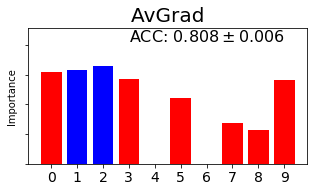

In [30]:
ag_importances = []
ag_metrics = []
for i in indices:
    X_tr = X[i[0]]
    X_val = X[i[1]]
    y_tr = y[i[0]]
    y_val = y[i[1]]
    K.clear_session()
    inp = Input((data_size))
    x = Dense(50,activation='tanh')(inp)
    x = Dense(25,activation='tanh')(x)
    x = Dense(10,activation='tanh')(x)
    if(dataset_type=="linear" or dataset_type=="regression"):x = Dense(1,activation='linear')(x)
    elif (dataset_type=="orange_skin"):x = Dense(1,activation='sigmoid')(x)
    elif (dataset_type=="XOR"):x = Dense(4,activation='softmax')(x)
    mod_new = Model(inputs=inp,outputs=x)
    if(dataset_type=="linear" or dataset_type=="regression"):
        mod_new.compile(optimizer='adam',loss='mse')
    elif (dataset_type=="orange_skin"):
        mod_new.compile(optimizer='adam',loss=K.binary_crossentropy,metrics=[keras.metrics.BinaryAccuracy()])
    elif (dataset_type=="XOR"):
        mod_new.compile(optimizer='adam',loss=K.categorical_crossentropy,metrics=[keras.metrics.CategoricalAccuracy()])
    mod_new.fit(X_tr,y_tr,batch_size=32,epochs=540,validation_data=(X_val,y_val),validation_freq=20)
    dg = np.mean(np.abs(MaskOptimizer.gradient(mod_new,X_val)[0]),axis=0)
    ag_importances.append(dg)
    ag_metrics.append(mod_new.evaluate(X_te,y_te))
print(ag_importances)
ag_metrics = np.array(ag_metrics)
ag_best_features = ResultSaver.get_feature_set_from_importances(ag_importances,n_top=unmasked_data_size)
#ag_masks = np.array([np.squeeze(get_boolean_mask(f)) for f in ag_features])
#print(np.array(ag_importances)*ag_masks)
#if(dataset_type=="linear" or dataset_type=="regression"):
#    save_graphic_importances(np.array(ag_importances)*ag_masks,"AvGrad",metric=ag_metrics)  
#else:
#    save_graphic_importances(np.array(ag_importances)*ag_masks,"AvGrad",metric=ag_metrics[:,1])  
if(dataset_type=="orange_skin" or dataset_type=="XOR"):
    rs.update("AvGrad",dataset_type,imp=np.array(ag_importances),perf=ag_metrics[:,1] )
else:
    rs.update("AvGrad",dataset_type,imp=np.array(ag_importances),perf=ag_metrics )



In [100]:
y_pred = np.squeeze(mod_new.predict(X_te))
print(np.squeeze(y_pred))
print(y_te)
print(np.mean((y_pred-y_te)*(y_pred-y_te)))

[-0.5081349  -0.6149275  -0.9634071  ... -0.47124603 -0.9742577
  0.09852562]
[-0.78942996  0.00358807 -0.52197759 ... -1.03701053 -1.0932392
  0.16038883]
0.07304889170978704


1024/1024 [==============================] - 0s 28us/sample - loss: 1.0192
Added feature: 3 with MSE: 0.5356224495917559
1024/1024 [==============================] - 0s 19us/sample - loss: 0.5367
Added feature: 0 with MSE: 0.31144067039713264
1024/1024 [==============================] - 0s 39us/sample - loss: 0.3191
Added feature: 2 with MSE: 0.19794017914682627
1024/1024 [==============================] - 0s 44us/sample - loss: 0.2031
Added feature: 1 with MSE: 0.1652507905382663
1024/1024 [==============================] - 0s 38us/sample - loss: 0.1770
Added feature: 9 with MSE: 0.17696580197662115
[array([4., 2., 3., 5., 0., 0., 0., 0., 0., 1.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]
[3 0 2 1 9]
1024/1024 [==============================] - 0s 24us/sample - loss: 1.0233
Added feature: 3 with MSE: 0.531184010207653
1024/1024 [===

1024/1024 [==============================] - 0s 43us/sample - loss: 0.2005
Added feature: 1 with MSE: 0.16554527613334358
1024/1024 [==============================] - 0s 32us/sample - loss: 0.1794
Added feature: 5 with MSE: 0.16837382968515158
[array([4., 2., 3., 5., 0., 0., 0., 0., 0., 1.]), array([4., 2., 3., 5., 1., 0., 0., 0., 0., 0.]), array([4., 2., 3., 5., 1., 0., 0., 0., 0., 0.]), array([4., 2., 3., 5., 0., 0., 1., 0., 0., 0.]), array([4., 2., 3., 5., 0., 1., 0., 0., 0., 0.])]
[3 0 2 1 5]
[array([3, 0, 2, 1, 9]), array([3, 0, 2, 1, 4]), array([3, 0, 2, 1, 4]), array([3, 0, 2, 1, 6]), array([3, 0, 2, 1, 5])]
Updated importances: [[4. 2. 3. 5. 0. 0. 0. 0. 0. 1.]
 [4. 2. 3. 5. 1. 0. 0. 0. 0. 0.]
 [4. 2. 3. 5. 1. 0. 0. 0. 0. 0.]
 [4. 2. 3. 5. 0. 0. 1. 0. 0. 0.]
 [4. 2. 3. 5. 0. 1. 0. 0. 0. 0.]]
Updated masks: [[1. 1. 1. 1. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 1. 0. 0. 0.]
 [1. 1. 1. 1. 0. 1. 0. 0. 0. 0.]]
MEtric: [

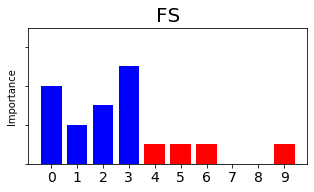

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier

fs_best_features=[]
fs_importances=[np.zeros(data_size) for i in range(unmasked_data_size)]
fold_number = 0
for j in indices:
    X_tr = X[j[0]]
    X_val = X[j[1]]
    y_tr = y[j[0]]
    y_val = y[j[1]]
    #if(dataset_type=="XOR" ):
    #    y_tr = np.nonzero(y_tr)
    #    y_val = np.nonzero(y_val)   
    best_features_LR = []
    available_features = [i for i in range(data_size)]
    for i in range(unmasked_data_size):
        best_mse = 100.0
        if(dataset_type=="XOR" or dataset_type=="orange_skin" ):
            best_mse = 0.0
        best_feature_index = 100
        for j in range(len(available_features)):
            used_features = best_features_LR + [available_features[j]]
            K.clear_session()
            inp = Input((len(used_features)))
            x = Dense(50,activation='tanh')(inp)
            x = Dense(25,activation='tanh')(x)
            x = Dense(10,activation='tanh')(x)
            if(dataset_type=="linear" or dataset_type=="regression"):x = Dense(1,activation='linear')(x)
            elif (dataset_type=="orange_skin"):x = Dense(1,activation='sigmoid')(x)
            elif (dataset_type=="XOR"):x = Dense(4,activation='softmax')(x)
            mod_new = Model(inputs=inp,outputs=x)
            if(dataset_type=="linear" or dataset_type=="regression"):mod_new.compile(optimizer='adam',loss='mse')
            elif (dataset_type=="orange_skin"):mod_new.compile(optimizer='adam',loss=K.binary_crossentropy,metrics=[keras.metrics.BinaryAccuracy()])
            elif (dataset_type=="XOR"):mod_new.compile(optimizer='adam',loss=K.categorical_crossentropy,metrics=[keras.metrics.CategoricalAccuracy()])
            callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
            mod_new.fit(X_tr[:,used_features],y_tr,batch_size=32,epochs=10000,validation_data=(X_val[:,used_features],y_val),validation_freq=1,callbacks=[callback],verbose=0)
            
            #if(dataset_type=="linear"):
            #    model = LinearRegression()
            #elif(dataset_type=="XOR" or dataset_type=="orange_skin" ):
            #    model = RandomForestClassifier(n_estimators=120,max_depth=12)
            #elif(dataset_type=="regression"):
            #    model = RandomForestRegressor(n_estimators=120,max_depth=12)
            #model = mod_new.fit(X_tr[:,used_features], y_tr)     
            
            if(dataset_type=="XOR" or dataset_type=="orange_skin"):
                #mse_te = model.score(X_val[:,used_features],y_val)
                mse_te = mod_new.evaluate(X_te[:,used_features],y_te)[1]
                if(mse_te > best_mse):
                    best_mse = mse_te
                    best_feature_index = j
            else:
                #y_pred = model.predict(X_val[:,used_features])
                #mse_te = np.mean((y_pred-y_val)*(y_pred-y_val))
                mse_te = mod_new.evaluate(X_te[:,used_features],y_te)
                if(mse_te < best_mse):
                    best_mse = mse_te
                    best_feature_index = j
        print("Added feature: "+str(available_features[best_feature_index])+" with MSE: "+str(best_mse))
        best_features_LR += [available_features[best_feature_index]]
        fs_importances[fold_number][available_features[best_feature_index]]= unmasked_data_size-i
        del available_features[best_feature_index]
    fs_best_features.append(np.array(best_features_LR))
    print(fs_importances)
    print(fs_best_features[-1])
    fold_number+=1

print(fs_best_features)
fs_importances=np.array(fs_importances)
#save_graphic_importances(get_importances_from_feature_set(fs_best_features),"FS",metric=None)  
rs.update("FS",dataset_type,imp=fs_importances)

[ 2  3  1  4 10  9  7  6  8  5]
[ 3  2  1  4  6 10  9  7  8  5]
[ 2  3  1  4  9 10  8  7  6  5]
[ 2  3  1  4 10  9  8  7  6  5]
[ 2  3  1  4  8 10  9  7  6  5]
[array([4, 3, 5, 2, 0, 0, 0, 0, 0, 1]), array([3, 4, 5, 2, 0, 0, 0, 0, 0, 1]), array([4, 3, 5, 2, 0, 0, 0, 0, 0, 1]), array([4, 3, 5, 2, 0, 0, 0, 0, 0, 1]), array([4, 3, 5, 2, 0, 0, 0, 0, 0, 1])]
Updated importances: [[4. 3. 5. 2. 0. 0. 0. 0. 0. 1.]
 [3. 4. 5. 2. 0. 0. 0. 0. 0. 1.]
 [4. 3. 5. 2. 0. 0. 0. 0. 0. 1.]
 [4. 3. 5. 2. 0. 0. 0. 0. 0. 1.]
 [4. 3. 5. 2. 0. 0. 0. 0. 0. 1.]]
Updated masks: [[1. 1. 1. 1. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 1.]]
MEtric: []
[3.8 3.2 5.  2.  0.  0.  0.  0.  0.  1. ]
Detecting common features: [0 1 2 3 9]
Common feature: 0
Common feature: 1
Common feature: 2
Common feature: 3
Common feature: 9


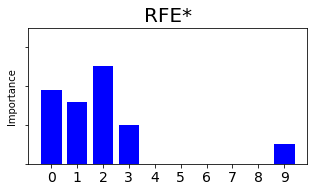

In [52]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier

rfe_best_features=[]
rfe_best_importances=[]

for i in indices:
    X_tr = X[i[0]]
    X_val = X[i[1]]
    y_tr = y[i[0]]
    y_val = y[i[1]]
    if(dataset_type=="XOR"):
        y_tr = np.nonzero(y_tr)[1]
        y_val = np.nonzero(y_val)[1]
    if(dataset_type=="linear"):
        model = LinearRegression()
    elif(dataset_type=="XOR" or dataset_type=="orange_skin" ):
        #model = svm.SVC(decision_function_shape='ovo',kernel='linear')
        model = RandomForestClassifier(n_estimators=120)
    elif(dataset_type=="regression"):
        model = svm.SVR(kernel='linear',gamma="scale",C=1)
    selector = RFE(model, 1, step=1)
    selector = selector.fit(X_tr, y_tr)
    print(selector.ranking_)
    rfe_best_features.append(np.squeeze(np.argwhere(selector.ranking_<=unmasked_data_size)))
    rfe_best_importances.append(np.where(selector.ranking_<=unmasked_data_size,np.abs(6-selector.ranking_),0))
print(rfe_best_importances)
#save_graphic_importances(get_importances_from_feature_set(rfe_best_features),"RFE",metric=None)  
#rs.update("RFE",dataset_type,imp=ResultSaver.get_importances_from_feature_set(rfe_best_features))
rs.update("RFE",dataset_type,imp=np.array(rfe_best_importances).astype(np.float16))

In [ ]:
from sklearn.linear_model import ElasticNet,LinearRegression
import itertools
def evaluate_subset_by_linear_reg(feature_indices,X_tr,y_tr,X_te,y_te):
    model = LinearRegression()
    used_X_tr = X_tr[:,feature_indices]
    model = model.fit(used_X_tr, y_tr)
    y_pred = model.predict(used_X_tr)
    train_perf = (np.mean((y_pred-y_tr)*(y_pred-y_tr)))
    y_pred = model.predict(X_te[:,feature_indices])
    test_perf = (np.mean((y_pred-y_te)*(y_pred-y_te)))
    return train_perf,test_perf
def evaluate_subset_by_linear_reg_Kfold(feature_indices,X,y,k_fold_indices):
    train_perf=[]
    test_perf=[]
    for indices in k_fold_indices:
        X_tr = X[indices[0]]
        X_val = X[indices[1]]
        y_tr = y[indices[0]]
        y_val = y[indices[1]]
        model = LinearRegression()
        used_X_tr = X_tr[:,feature_indices]
        model = model.fit(used_X_tr, y_tr)
        y_pred = model.predict(used_X_tr)
        train_perf.append(np.mean((y_pred-y_tr)*(y_pred-y_tr)))
        y_pred = model.predict(X_te[:,feature_indices])
        test_perf.append(np.mean((y_pred-y_te)*(y_pred-y_te)))
    train_perf = np.array(train_perf)
    test_perf = np.array(test_perf)
    return np.mean(train_perf),np.mean(test_perf),np.std(train_perf),np.std(test_perf)
def get_possible_subsets(subset_size,min_feature=10):
    possible_features = np.arange(min_feature,data_size)
    subset_combinations = itertools.combinations(possible_features,subset_size)
    return np.array([list(subset) for subset in subset_combinations])
def find_index_of_subset(in_sorted_subsets,subsets):
    indices = []
    print(subsets)
    if(len(subsets) != 5):
        subsets= subsets[None,:]
    for subset in subsets:
        print(subset)
        subset = np.sort(subset)
        for i in range(len(in_sorted_subsets)):
            if(np.all(subset==in_sorted_subsets[i])):
                indices.append(i)
    return np.array(indices)
            

In [78]:
subsets = get_possible_subsets(unmasked_data_size,0)
performances = np.zeros((len(subsets),4))
for index in range(len(subsets)):
    performances[index,:] = evaluate_subset_by_linear_reg_Kfold(subsets[index],X,y,indices)
    #performances[index,:] = evaluate_subset_by_linear_reg(subsets[index],X,y,X_te,y_te)
sorted_indices = np.argsort(performances[:,1])
sorted_subsets = subsets[sorted_indices]
for i in range(5):
    print("Top 5: "+str(i+1)+" : "+str(sorted_subsets[i])+" perf: "+str(performances[sorted_indices[i],:]))

Top 5: 1 : [ 0  2  3  4  5  6  8 10] perf: [0.06880941 0.06562351 0.00295496 0.00059312]
Top 5: 2 : [0 2 3 4 5 6 8 9] perf: [0.06851682 0.06669375 0.00277831 0.00040157]
Top 5: 3 : [ 1  2  3  4  5  6  8 10] perf: [0.06996509 0.06773549 0.00219419 0.00069886]
Top 5: 4 : [1 2 3 4 5 6 8 9] perf: [0.06961366 0.06829533 0.00183726 0.00054216]
Top 5: 5 : [1 2 3 4 5 6 7 9] perf: [0.06643609 0.07190982 0.00061851 0.00035044]


In [139]:

SN_index=find_index_of_subset(sorted_subsets,sn_best_features)
print("My method index: "+str(SN_index))
CCM_index=find_index_of_subset(sorted_subsets,ccm_best_features)
print(CCM_index)
print(sorted_subsets[SN_index])
print(sorted_subsets[CCM_index])
lasso_index=find_index_of_subset(sorted_subsets,lasso_best_features)

RF_index=find_index_of_subset(sorted_subsets,rf_best_features)
LR_index=find_index_of_subset(sorted_subsets,fs_best_features)
RFE_index=find_index_of_subset(sorted_subsets,rfe_best_features)
DFS_index=find_index_of_subset(sorted_subsets,dfs_best_features)
AG_index=find_index_of_subset(sorted_subsets,ag_best_features)

BAHSIC_best_features = np.array([[3, 9, 4, 6, 2, 10, 0, 1], [8, 9, 4, 10, 6, 2, 0, 1], [9, 4, 8, 10, 6, 2, 0, 1], [8, 9, 4, 2, 10, 6, 0, 1], [3, 9, 4, 2, 10, 6, 0, 1]])


[[ 1  2  3  4  5  6  7  9]
 [ 1  2  3  4  5  6  7 10]
 [ 1  2  3  4  5  6  7  9]
 [ 1  2  3  4  5  6  7  9]
 [ 1  2  3  4  5  6  7  9]]
[1 2 3 4 5 6 7 9]
[ 1  2  3  4  5  6  7 10]
[1 2 3 4 5 6 7 9]
[1 2 3 4 5 6 7 9]
[1 2 3 4 5 6 7 9]
My method index: [4 5 4 4 4]
[array([1, 0, 2, 3, 4, 5, 6, 8]), array([1, 2, 0, 3, 4, 5, 6, 8]), array([1, 2, 0, 3, 4, 5, 6, 8]), array([0, 1, 2, 4, 3, 6, 5, 8]), array([1, 2, 0, 4, 3, 5, 6, 8])]
[1 0 2 3 4 5 6 8]
[1 2 0 3 4 5 6 8]
[1 2 0 3 4 5 6 8]
[0 1 2 4 3 6 5 8]
[1 2 0 4 3 5 6 8]
[123 123 123 123 123]
[[ 1  2  3  4  5  6  7  9]
 [ 1  2  3  4  5  6  7 10]
 [ 1  2  3  4  5  6  7  9]
 [ 1  2  3  4  5  6  7  9]
 [ 1  2  3  4  5  6  7  9]]
[[0 1 2 3 4 5 6 8]
 [0 1 2 3 4 5 6 8]
 [0 1 2 3 4 5 6 8]
 [0 1 2 3 4 5 6 8]
 [0 1 2 3 4 5 6 8]]
[array([7, 5, 6, 4, 3, 2, 0, 1]), array([7, 6, 5, 4, 3, 2, 0, 1]), array([7, 6, 5, 4, 3, 2, 0, 1]), array([7, 6, 5, 4, 3, 2, 0, 1]), array([7, 5, 6, 4, 3, 2, 0, 1])]
[7 5 6 4 3 2 0 1]
[7 6 5 4 3 2 0 1]
[7 6 5 4 3 2 0 1]
[7 6 5 

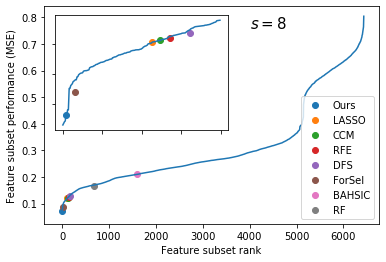

In [143]:
SN_x = np.mean(SN_index)
SN_y = np.mean(performances[sorted_indices[SN_index],1])

lasso_x = np.mean(lasso_index)
lasso_y = np.mean(performances[sorted_indices[lasso_index],1])

CCM_x = np.mean(CCM_index)
CCM_y = np.mean(performances[sorted_indices[CCM_index],1])

RFE_x = np.mean(RFE_index)
RFE_y = np.mean(performances[sorted_indices[RFE_index],1])

DFS_x = np.mean(DFS_index)
DFS_y = np.mean(performances[sorted_indices[DFS_index],1])

FS_x = np.mean(LR_index)
FS_y = np.mean(performances[sorted_indices[LR_index],1])

RF_x = np.mean(RF_index)
RF_y = np.mean(performances[sorted_indices[RF_index],1])

BAHSIC_x = np.mean(BAHSIC_index)
BAHSIC_y = np.mean(performances[sorted_indices[BAHSIC_index],1])

plt.plot(performances[sorted_indices,1])
plt.scatter(SN_x,SN_y,label="Ours")
plt.scatter(lasso_x,lasso_y,label="LASSO")
plt.scatter(CCM_x,CCM_y,label="CCM")

plt.scatter(RFE_x,RFE_y,label="RFE")
plt.scatter(DFS_x,DFS_y,label="DFS")
plt.scatter(FS_x,FS_y,label="ForSel")
plt.scatter(BAHSIC_x,BAHSIC_y,label="BAHSIC")

plt.scatter(RF_x,RF_y,label="RF")

plt.legend(loc=4)
plt.xlabel("Feature subset rank")
plt.ylabel("Feature subset performance (MSE)")
plt.text(4000,plt.ylim()[1]-((plt.ylim()[1]-plt.ylim()[0])/10), r'$s='+str(unmasked_data_size)+'$', fontsize=15)

sub_axes = plt.axes([.15, 0.45, .4, .4]) 

# plot the zoomed portion
#plt.show()
sub_axes.plot(performances[sorted_indices[:200],1])
sub_axes.scatter(SN_x,SN_y,label="SN")
sub_axes.scatter(lasso_x,lasso_y,label="LASSO")
sub_axes.scatter(CCM_x,CCM_y,label="CCM")

sub_axes.scatter(RFE_x,RFE_y,label="RFE")
sub_axes.scatter(DFS_x,DFS_y,label="DFS")
sub_axes.scatter(FS_x,FS_y,label="ForSel")
#sub_axes.scatter(BAHSIC_x,BAHSIC_y,label="BAHSIC")
sub_axes.set_yticklabels([])
sub_axes.set_xticklabels([])
#plt.legend()
plt.show()

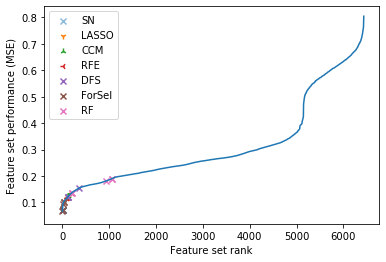

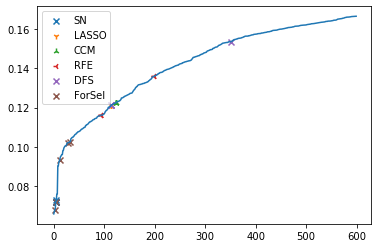

In [114]:
plt.plot(performances[sorted_indices,1])
plt.scatter(SN_index,performances[sorted_indices[SN_index],1],label="SN",marker="x",alpha=0.5)
plt.scatter(lasso_index,performances[sorted_indices[lasso_index],1],label="LASSO",marker="1")
plt.scatter(CCM_index,performances[sorted_indices[CCM_index],1],label="CCM",marker="2")

plt.scatter(RFE_index,performances[sorted_indices[RFE_index],1],label="RFE",marker="3")
plt.scatter(DFS_index,performances[sorted_indices[DFS_index],1],label="DFS",marker="x")
plt.scatter(LR_index,performances[sorted_indices[LR_index],1],label="ForSel",marker="x")
plt.scatter(RF_index,performances[sorted_indices[RF_index],1],label="RF",marker="x")

plt.legend()
plt.xlabel("Feature set rank")
plt.ylabel("Feature set performance (MSE)")
plt.show()
plt.plot(performances[sorted_indices[:600],1])
plt.scatter(SN_index,performances[sorted_indices[SN_index],1],label="SN",marker="x")
plt.scatter(lasso_index,performances[sorted_indices[lasso_index],1],label="LASSO",marker="1")
plt.scatter(CCM_index,performances[sorted_indices[CCM_index],1],label="CCM",marker="2")
#plt.scatter(RF_index,performances[sorted_indices[RF_index],1],label="RF",marker="x")

plt.scatter(RFE_index,performances[sorted_indices[RFE_index],1],label="RFE",marker="3")
plt.scatter(DFS_index,performances[sorted_indices[DFS_index],1],label="DFS",marker="x")
plt.scatter(LR_index,performances[sorted_indices[LR_index],1],label="ForSel",marker="x")
plt.legend()
plt.show()